In [1]:
%load_ext autoreload
%autoreload 2
import os
from configs import project_config
import matplotlib.pyplot as plt
import numpy as np
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF1_T256_H05_tl_110data_StbleTgt_WRMSE import \
    get_config
from configs.RecursiveVPSDE.LSTM_fQuadSinHF.recursive_LSTM_PostMeanScore_fQuadSinHF2_HighFTh_T256_H05_tl_110data_StbleTgt_WRMSE import \
    get_config
from configs.RecursiveVPSDE.LSTM_fBiPot.recursive_LSTM_PostMeanScore_fBiPot_T256_H05_tl_110data_StbleTgt_WRMSE import get_config

In [2]:
config = get_config()
assert config.deltaT == 1./256
num_paths = 10952

In [3]:
def rmse_ignore_nans(y_true, y_pred):
    assert (y_true.shape == y_pred.shape and len(y_pred.shape) == 1)
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)  # Ignore NaNs in both arrays
    return (np.mean((y_true[mask] - y_pred[mask]) ** 2))

In [4]:
if "fQuadSin" in config.data_path:
    minx = -1.5
    if config.sin_space_scale == 25.:
        ts_type = "fQuadSin2"
    else:
        ts_type = "fQuadSin1"
    include = (f"{config.deltaT:.3e}dT_{config.quad_coeff}a_{config.sin_coeff}b_{config.sin_space_scale}c").replace(
        ".", "")
elif "fBiPotSmall" in config.data_path:
    minx = -1.5
    ts_type = "fBiPotSmall"
    include = None
elif "fBiPot" in config.data_path:
    minx = -1.5
    ts_type = "fBiPot"
    include = (f"{config.deltaT:.3e}dT_{config.quartic_coeff}a_{config.quad_coeff}b_{config.const}c").replace(
        ".", "")
maxx = -minx
print(ts_type)

fBiPot


In [5]:
import os
import re
keepfiles = []
root_dir = project_config.ROOT_DIR + f"experiments/results/"
for file in os.listdir(root_dir):
    if "IIDNadaraya" in file and ts_type[:-1] in file and include in file and "DriftEvalExp" in file:
        keepfiles.append(root_dir+file)
print(len(keepfiles), ts_type)
assert len(keepfiles)>0, "No files found"
def extract_bw_number(s):
    match = s.split("/")[-1].split("_")[3][:-2]
    return float("0." + match)


keepfiles = sorted(keepfiles, key=extract_bw_number)
bws = [extract_bw_number(f) for f in keepfiles]
Xshape = np.load(keepfiles[0]).shape[0]
print(keepfiles)

12 fBiPot
['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftEvalExp_001bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_isdriftHats.npy', '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftEvalExp_00127bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_isdriftHats.npy', '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftEvalExp_0016bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_isdriftHats.npy', '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftEvalExp_00203bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_isdriftHats.npy', '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftEvalExp_00257bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_isdriftHats.npy', '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftEvalExp_00326bw_10952NPaths_00t0_390

In [6]:
vispaths = np.linspace(minx, maxx, Xshape)
if "QuadSin" in config.data_path:
    print(config.quad_coeff, config.sin_coeff, config.sin_space_scale, config.deltaT)
    is_true_drift = -2.*config.quad_coeff * vispaths.flatten() + config.sin_coeff * config.sin_space_scale*np.sin(config.sin_space_scale*vispaths.flatten())
elif "fSin" in config.data_path:
    is_true_drift = config.mean_rev*np.sin(vispaths.flatten())
elif "BiPot" in config.data_path:
    is_true_drift = -(4.*config.quartic_coeff * np.power(vispaths, 3) + 2.*config.quad_coeff * vispaths + config.const).flatten()
print(ts_type)

fBiPot


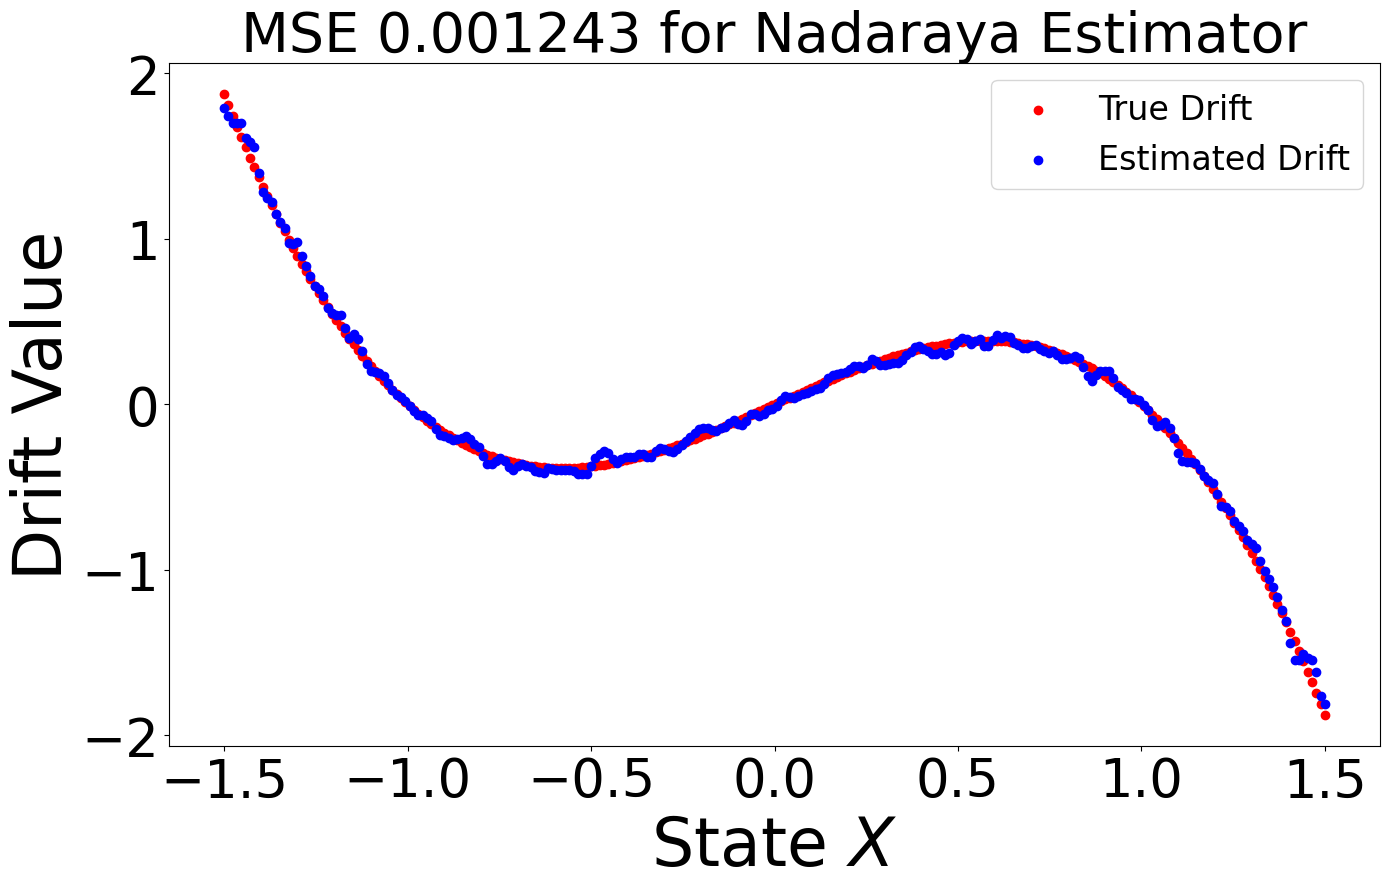

1e-05


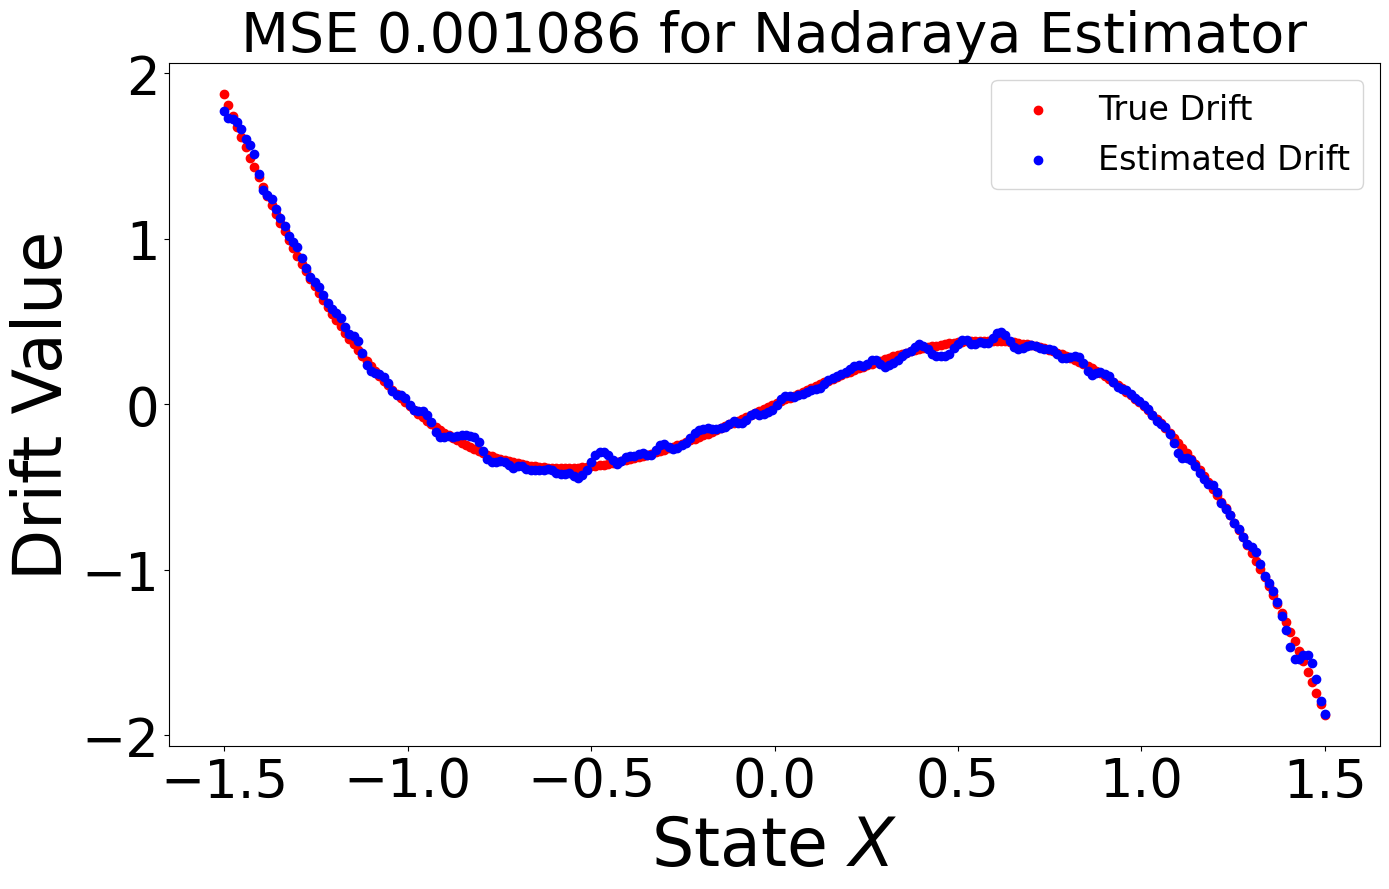

1.26e-05


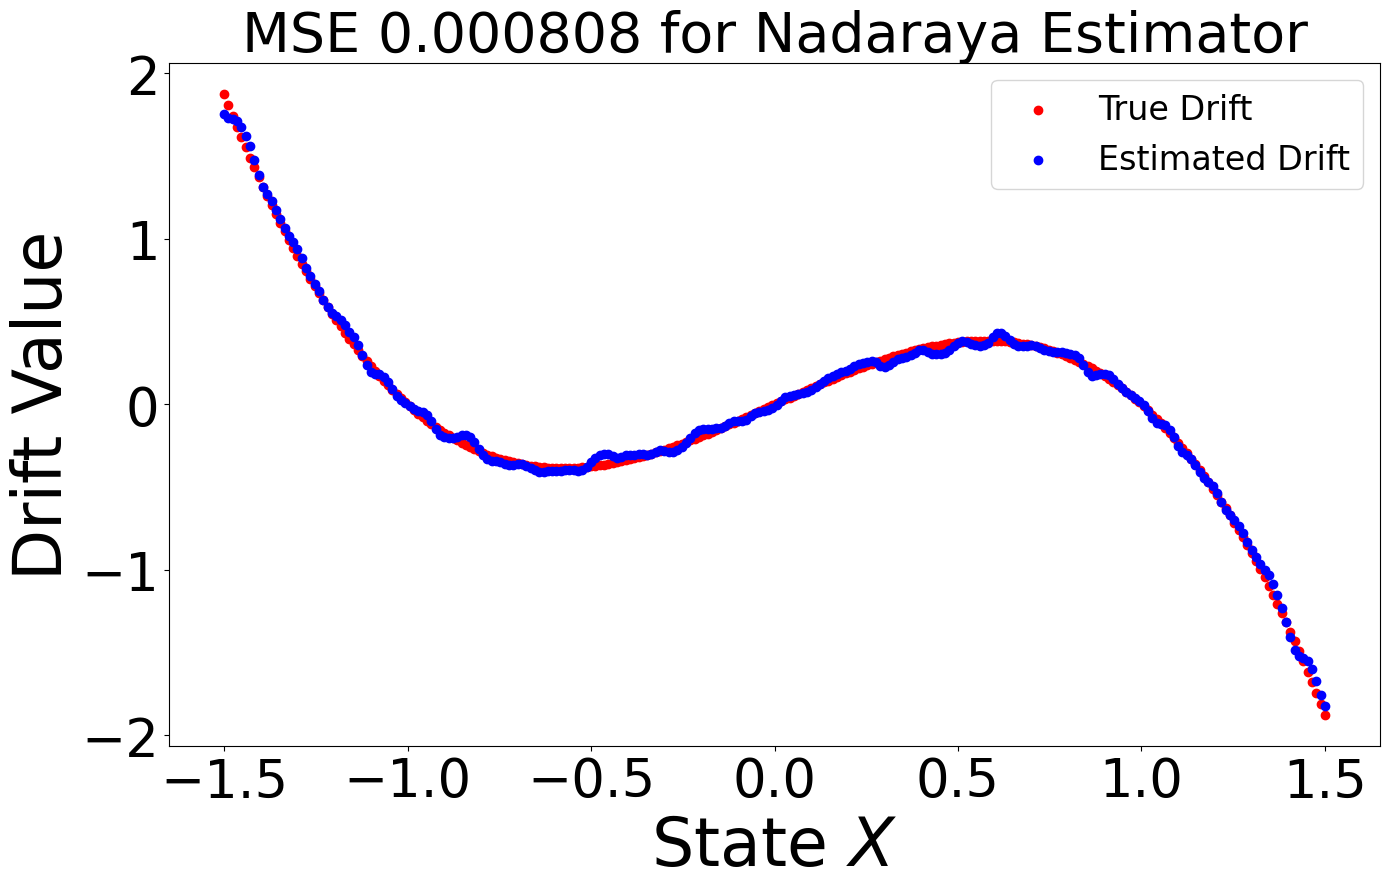

1.59e-05


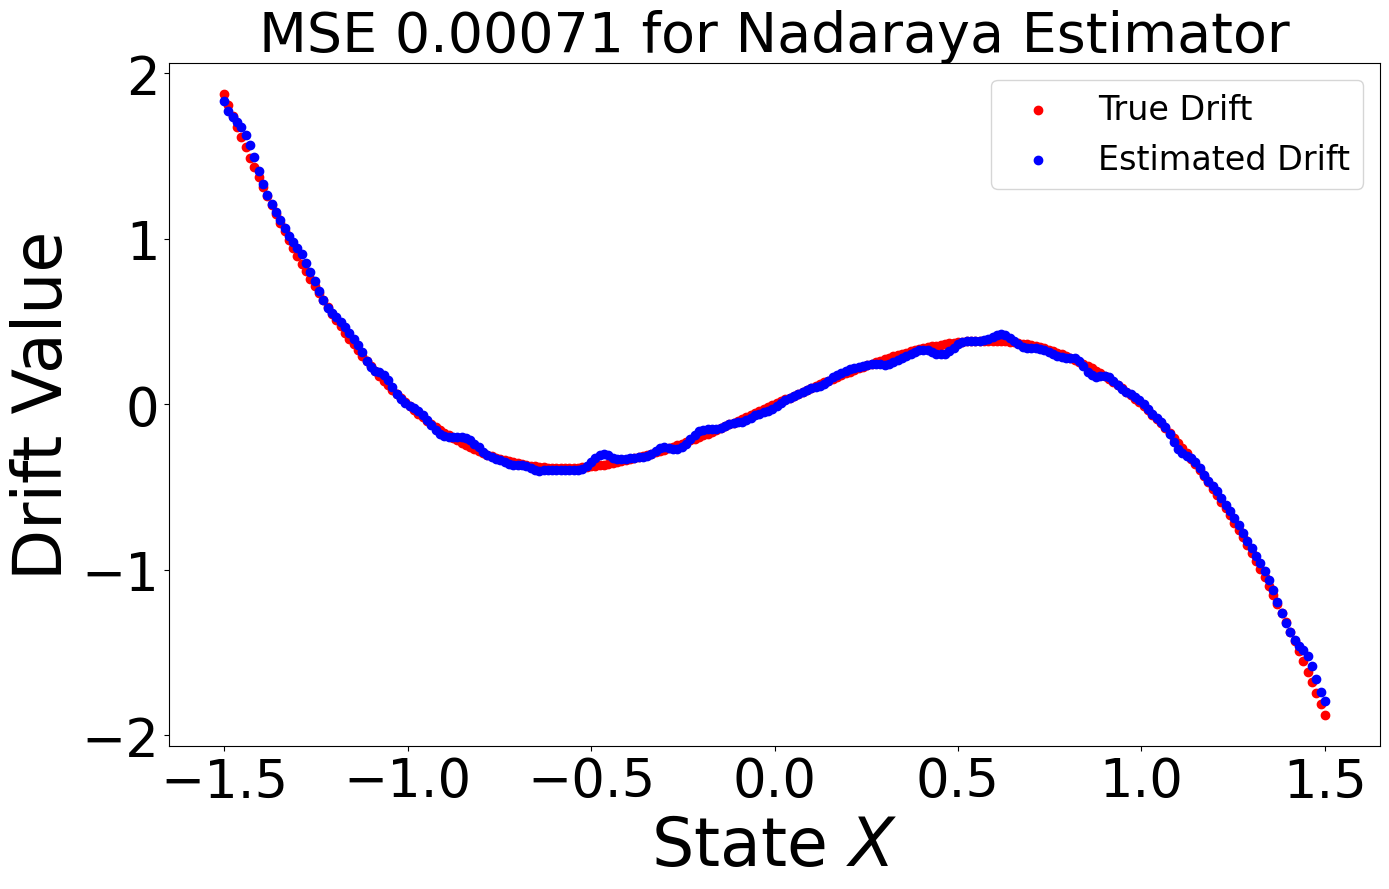

2.01e-05


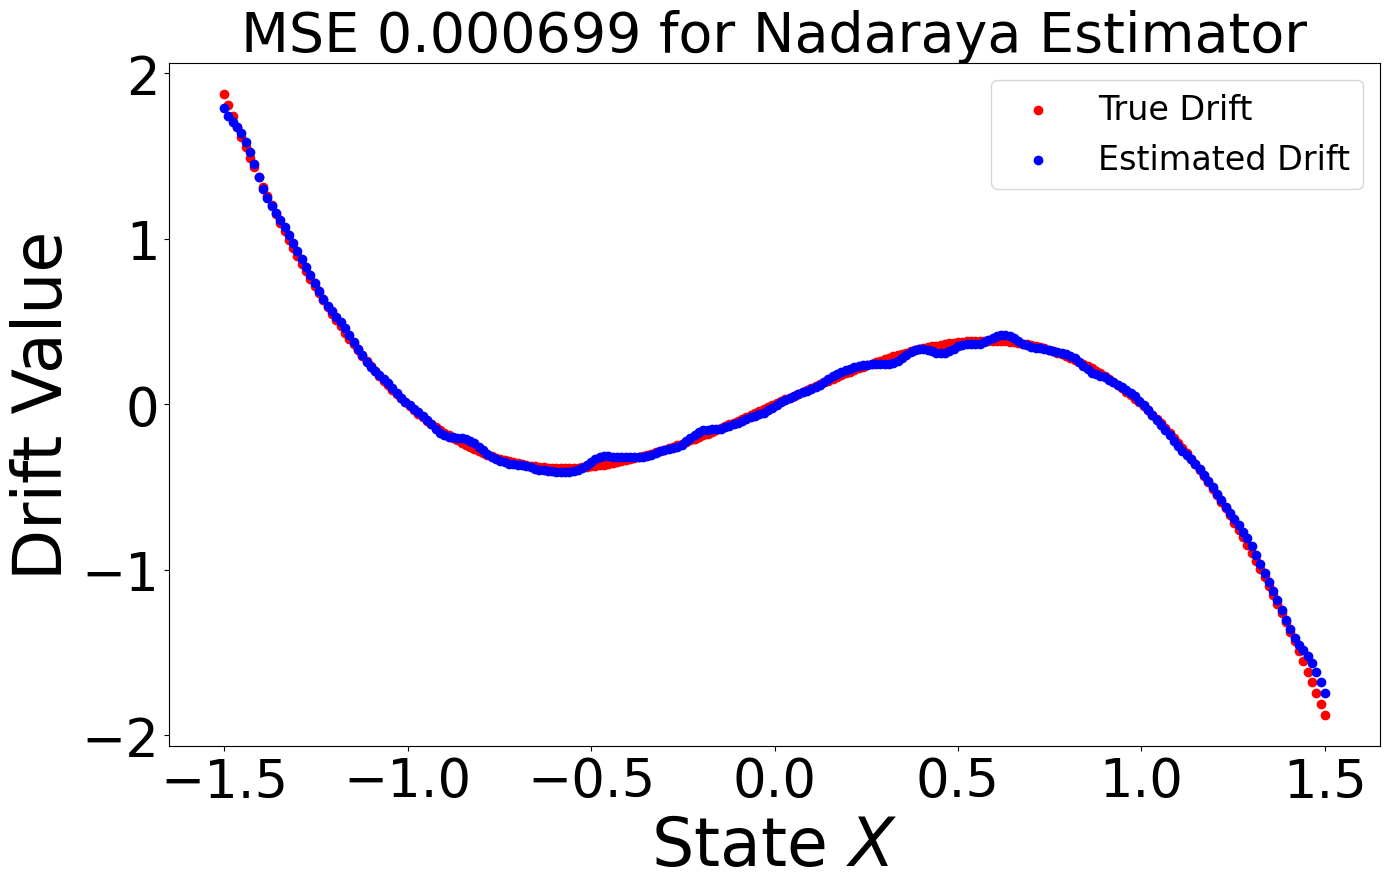

2.54e-05


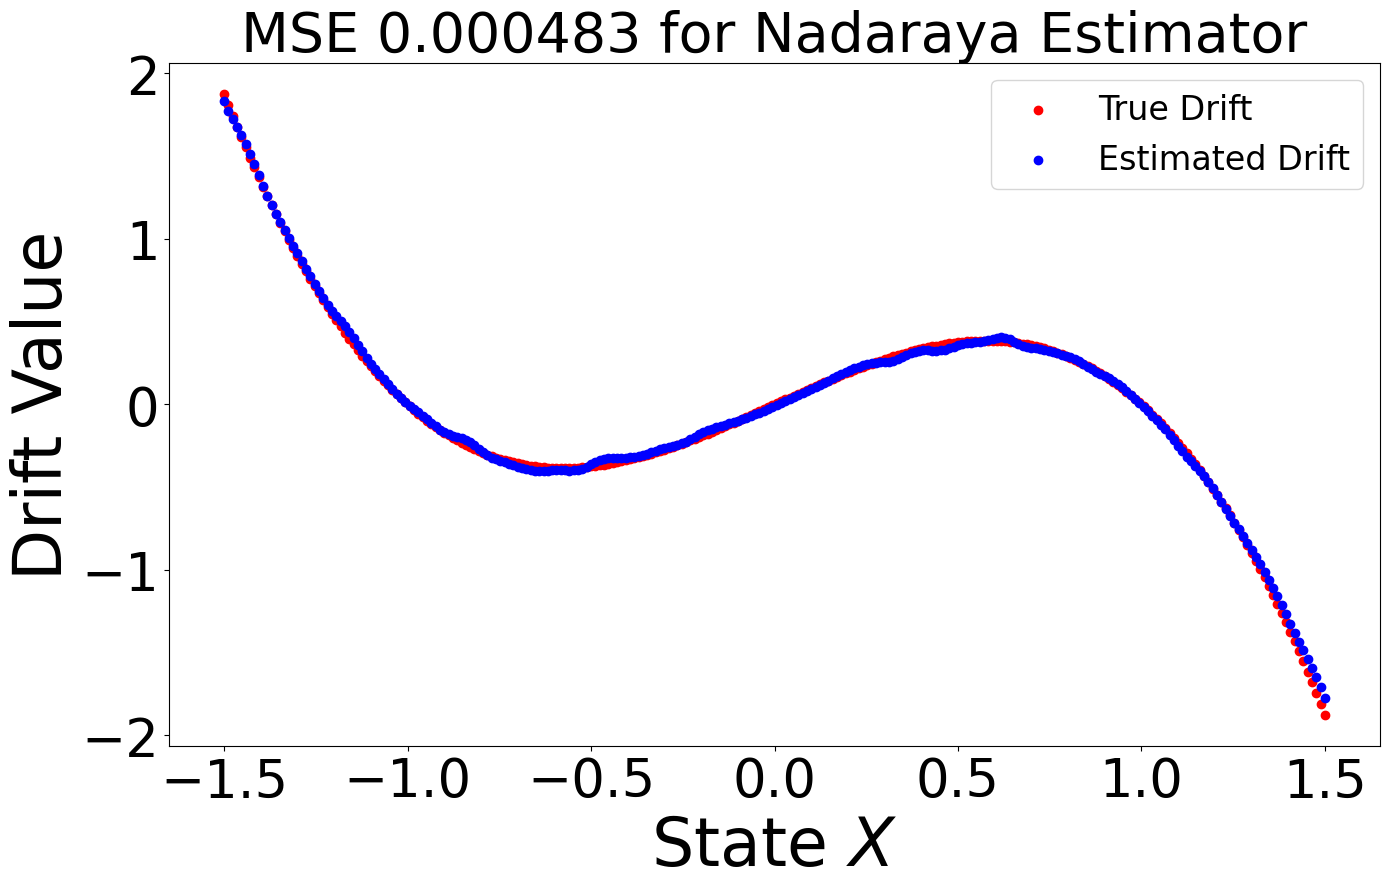

3.21e-05


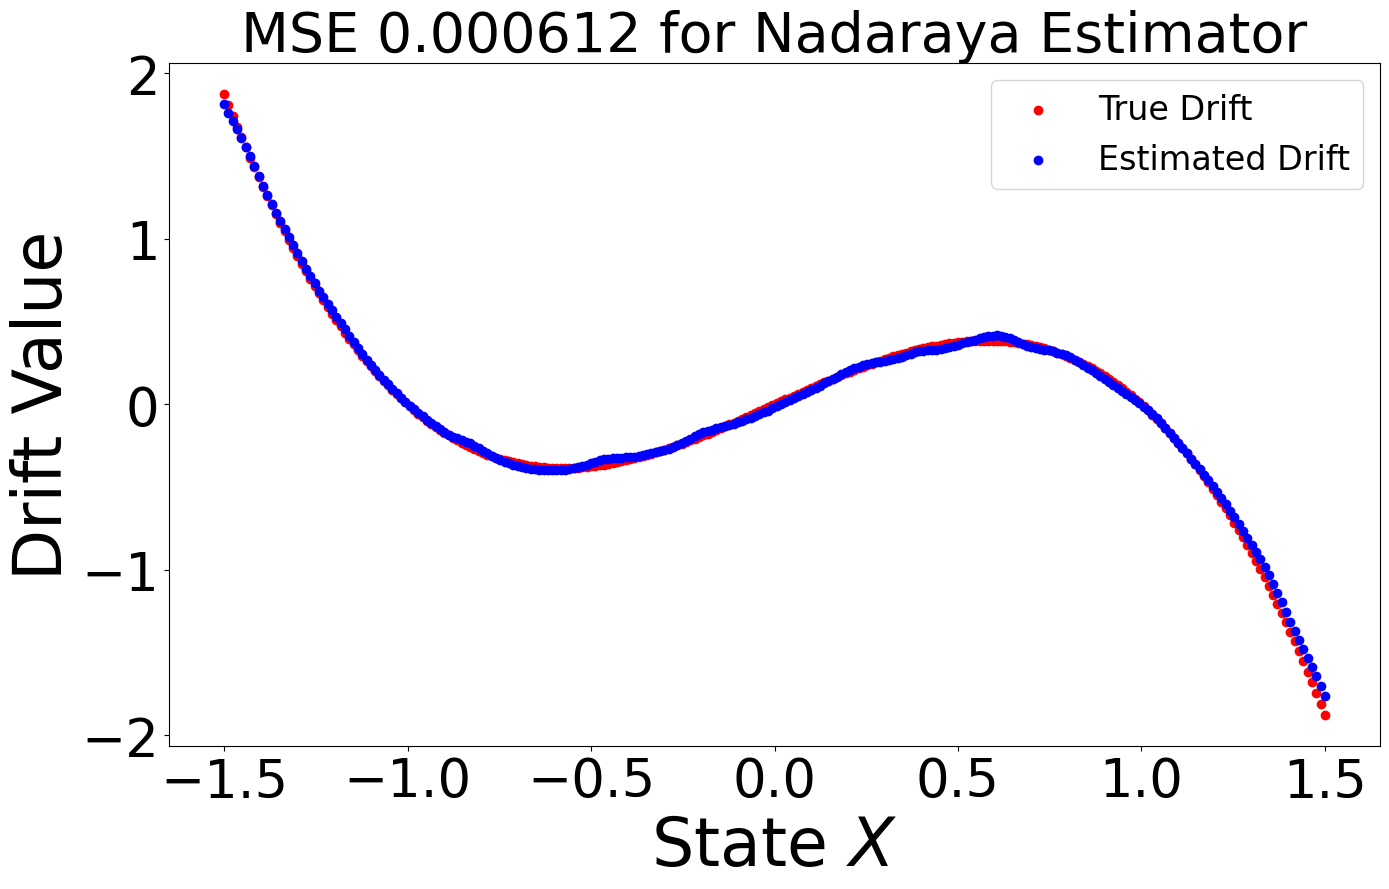

4.05e-05


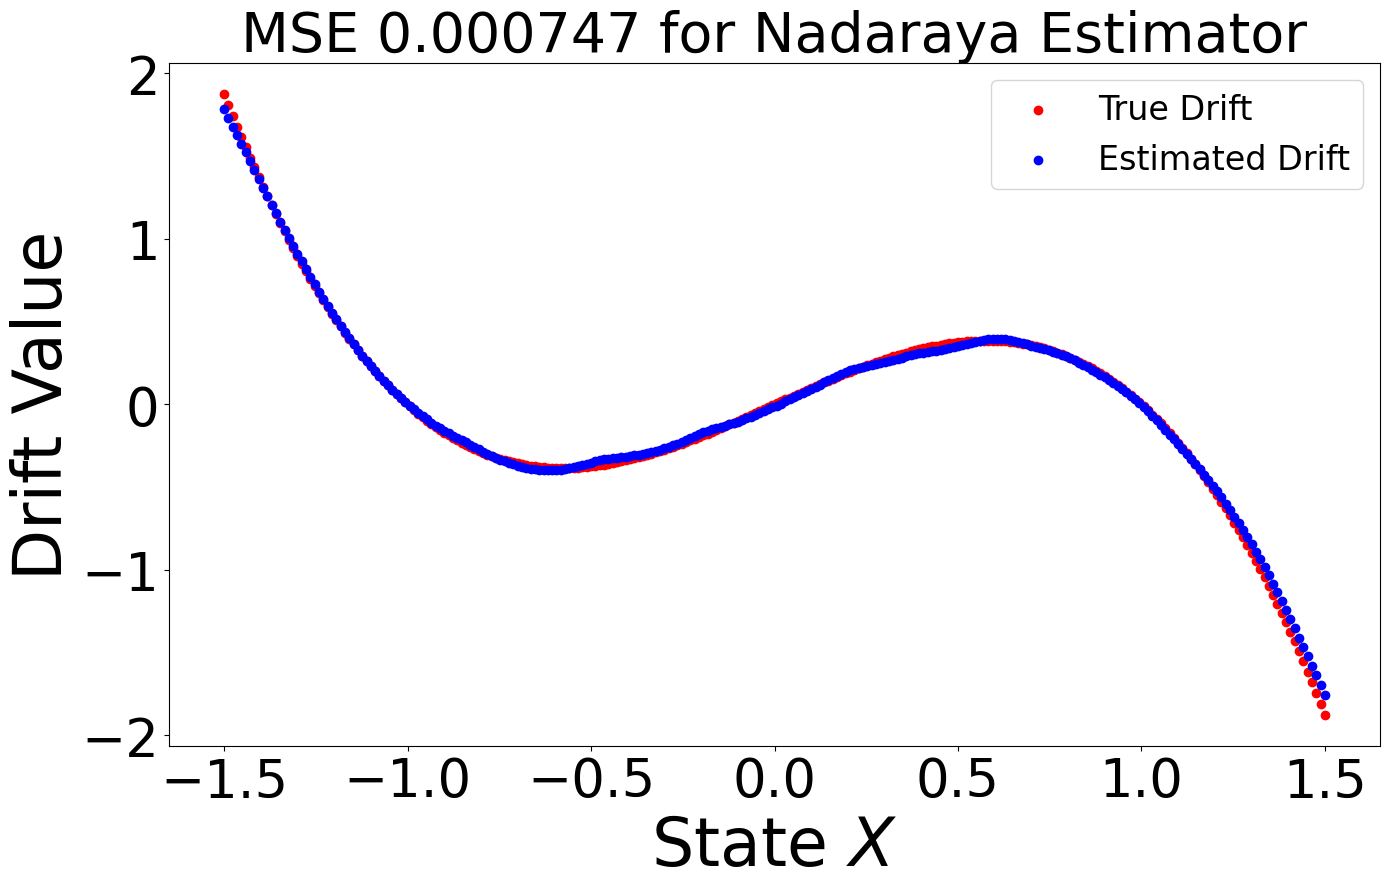

5.12e-05


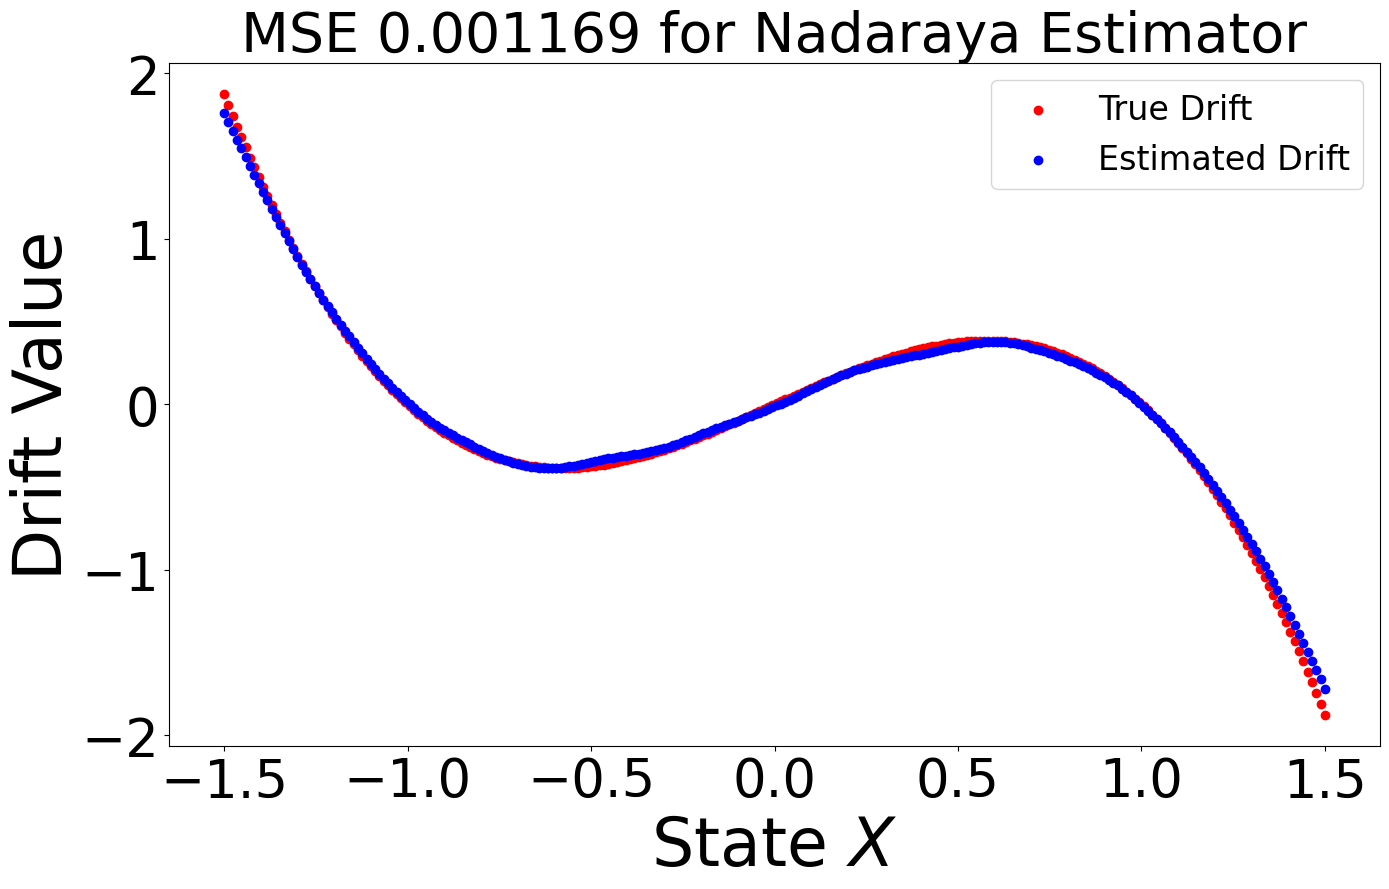

6.46e-05


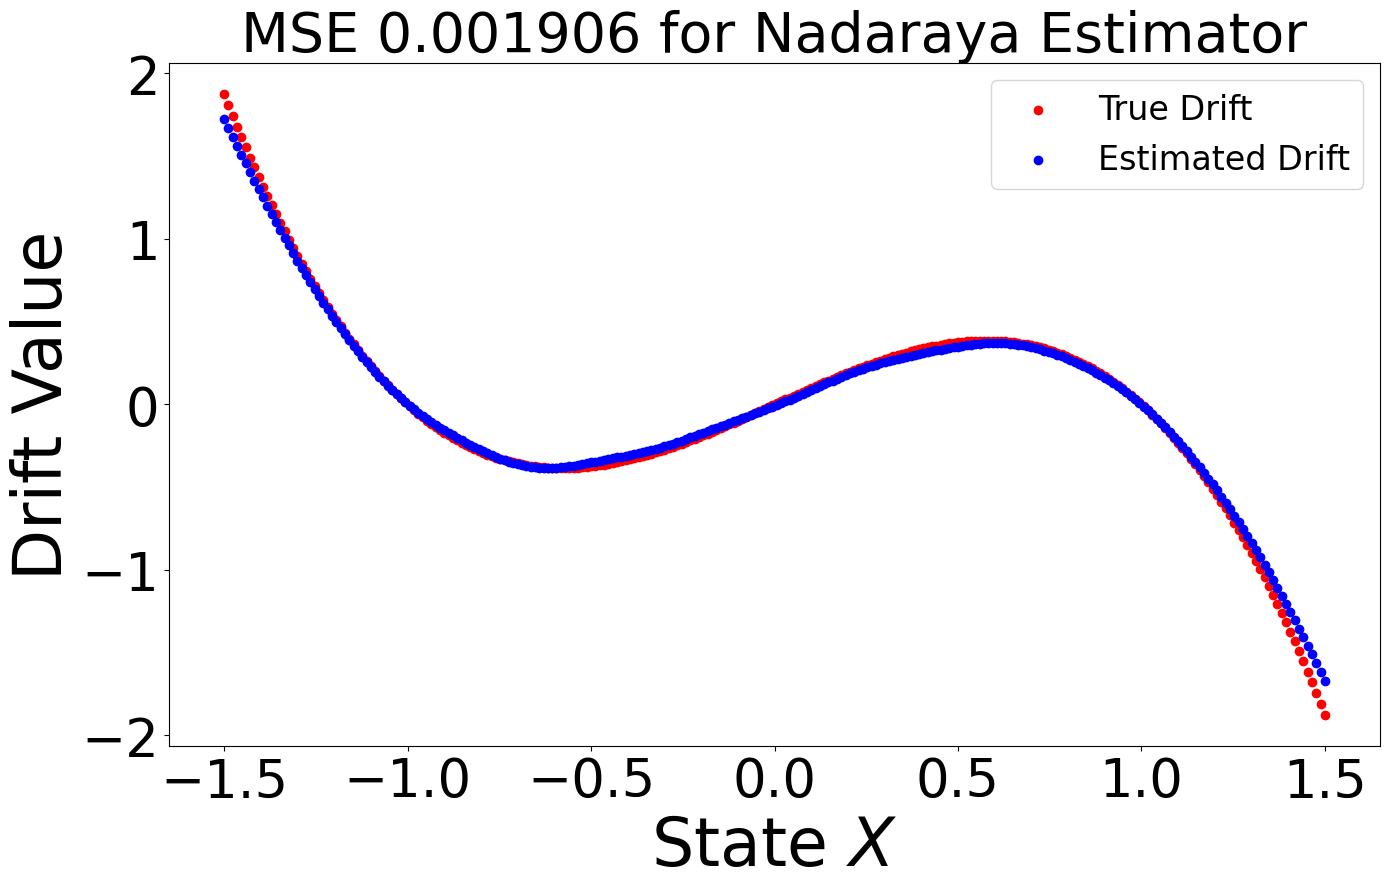

8.16e-05


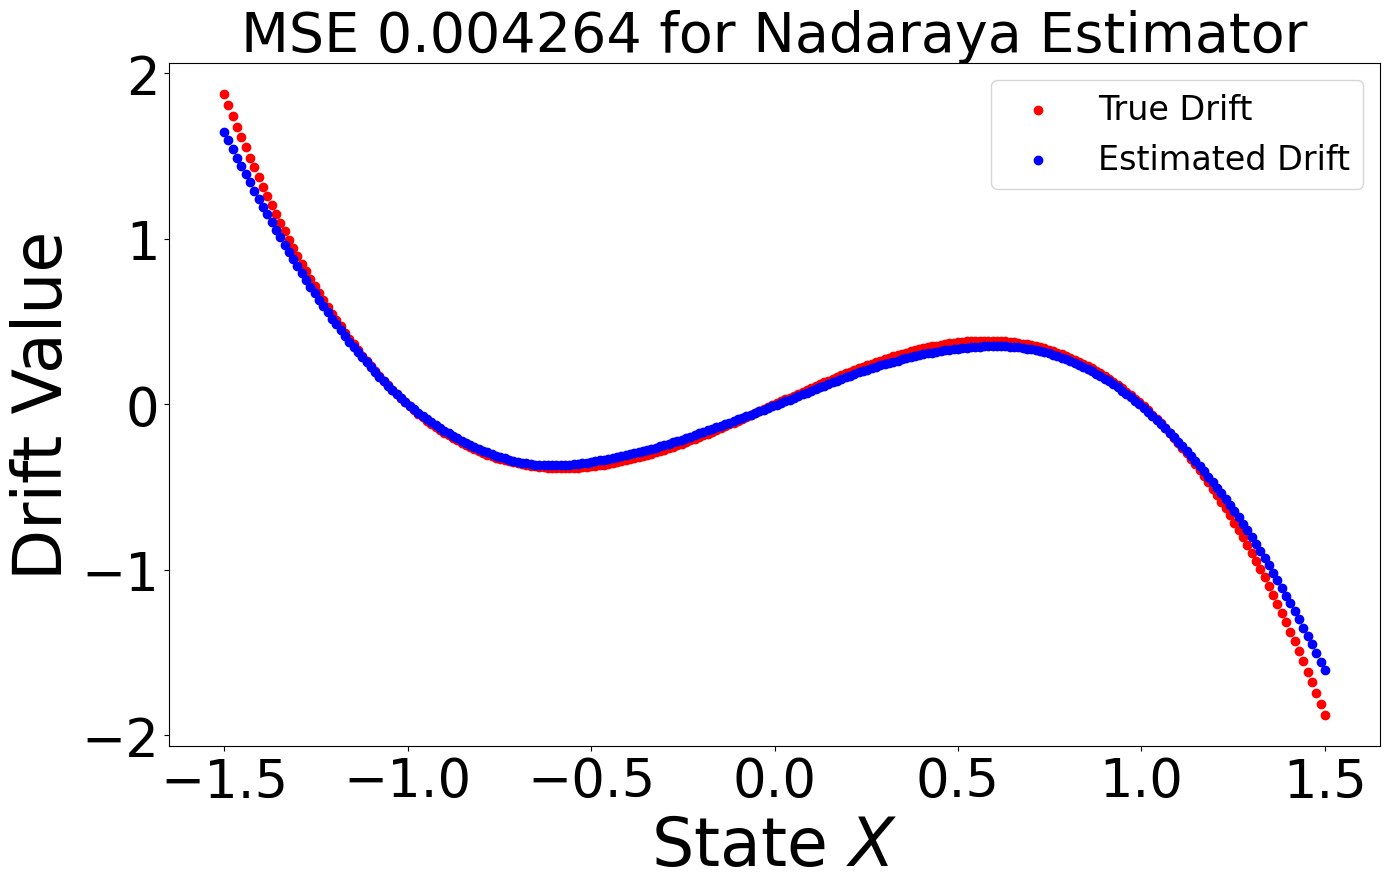

0.000103


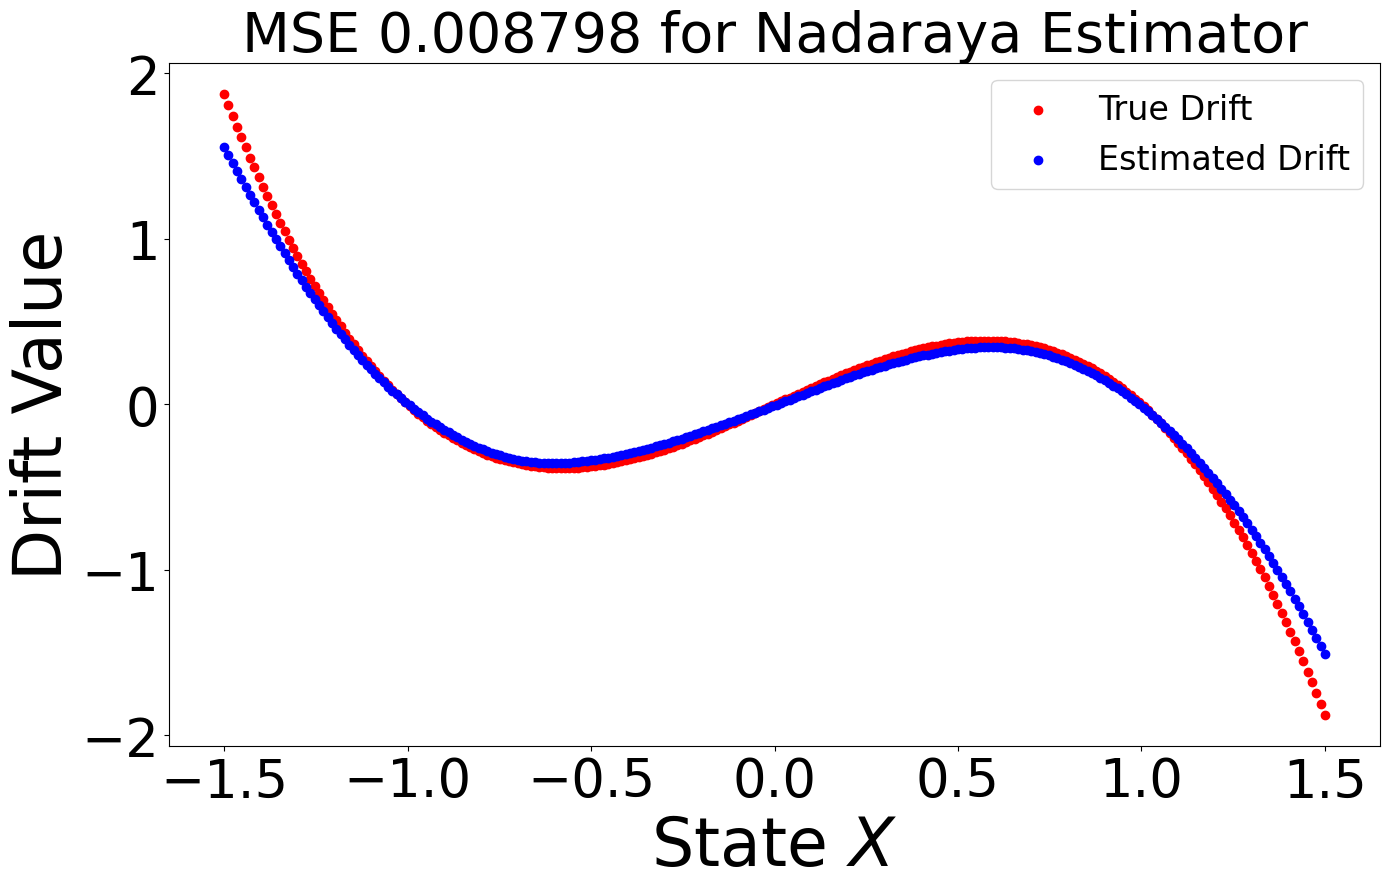

0.00013


In [12]:
curr_mse = np.inf
for f_idx in range(len(keepfiles)):
    bw = bws[f_idx]
    f = keepfiles[f_idx]
    try:
        is_drift = np.load(f).mean(axis=-1).flatten()
        mse = (rmse_ignore_nans(is_true_drift, is_drift))
        if mse < curr_mse:
            curr_mse = np.inf
            fig, ax = plt.subplots(figsize=(14,9))
            plt.scatter(vispaths, is_true_drift,label="True Drift", color="red")
            plt.scatter(vispaths, is_drift, label="Estimated Drift", color="blue")
            plt.legend(fontsize=18)
            plt.title(f"MSE {round(mse, 6)} for Nadaraya Estimator", fontsize=40)
            ax.tick_params(labelsize=38)
            plt.ylabel("Drift Value", fontsize=48)
            plt.xlabel(r"State $X$", fontsize=48)
            plt.legend(fontsize=24)
            plt.tight_layout()
            plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/IIDNadaraya_{ts_type}_DriftEvalExp_{round(bw, 6)}bw".replace(".","")+".png",  bbox_inches='tight')
            plt.show()
            plt.close()
            print(bw)
    except ValueError as e:
        plt.close()
        continue


In [8]:
def get_drifttrack_files(config):
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_dir = project_config.ROOT_DIR + f"experiments/results/"
    true_files = []
    local_files = []
    for file in os.listdir(root_dir):
        if "QuadSin" in ts_type:
            if "IIDNadaraya" in file and  "DriftTrack" in file and ts_type[:-1] in file and include in file and f"{config.sin_space_scale}c".replace(".", "") in file:
                print(file)
                if "true" in file:
                    true_files.append(root_dir+file)
                elif "local" in file:
                    local_files.append(root_dir+file)
        else:
            if "IIDNadaraya" in file and  "DriftTrack" in file and ts_type[:-1] in file and include in file:
                print(file)
                if "true" in file:
                    true_files.append(root_dir+file)
                elif "local" in file:
                    local_files.append(root_dir+file)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws

In [9]:
config = get_config()
true_files, local_files, bws = get_drifttrack_files(config=config)
local_files

IIDNadaraya_fBiPot_DriftTrack_0137957bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_true_states.npy
IIDNadaraya_fBiPot_DriftTrack_0000512bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy
IIDNadaraya_fBiPot_DriftTrack_0013394bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_true_states.npy
IIDNadaraya_fBiPot_DriftTrack_0001642bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_true_states.npy
IIDNadaraya_fBiPot_DriftTrack_0705859bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_true_states.npy
IIDNadaraya_fBiPot_DriftTrack_0559031bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_true_states.npy
IIDNadaraya_fBiPot_DriftTrack_0000126bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy
IIDNadaraya_fBiPot_DriftTrack_00001bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy
IIDNadaraya_fBiPot_DriftTrack_0000405bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy
IIDNadaraya_fBiPot_DriftTrack_0000405bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_true_states.npy
IIDNadaraya_fBiPot

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftTrack_00001bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftTrack_0000126bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftTrack_0000159bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftTrack_0000201bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftTrack_0000254bw_10952NPaths_00t0_3906e-03dT_025a_-05b_00c_local_states.npy',
 '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/IIDNadaraya_fBiPot_DriftTrack_0000321bw_10952NPaths_00t0_39

0.0023627483433988497 0.00037268973049155813 inf 0
0.0018937552615184076 0.00037472080872409316 inf 1


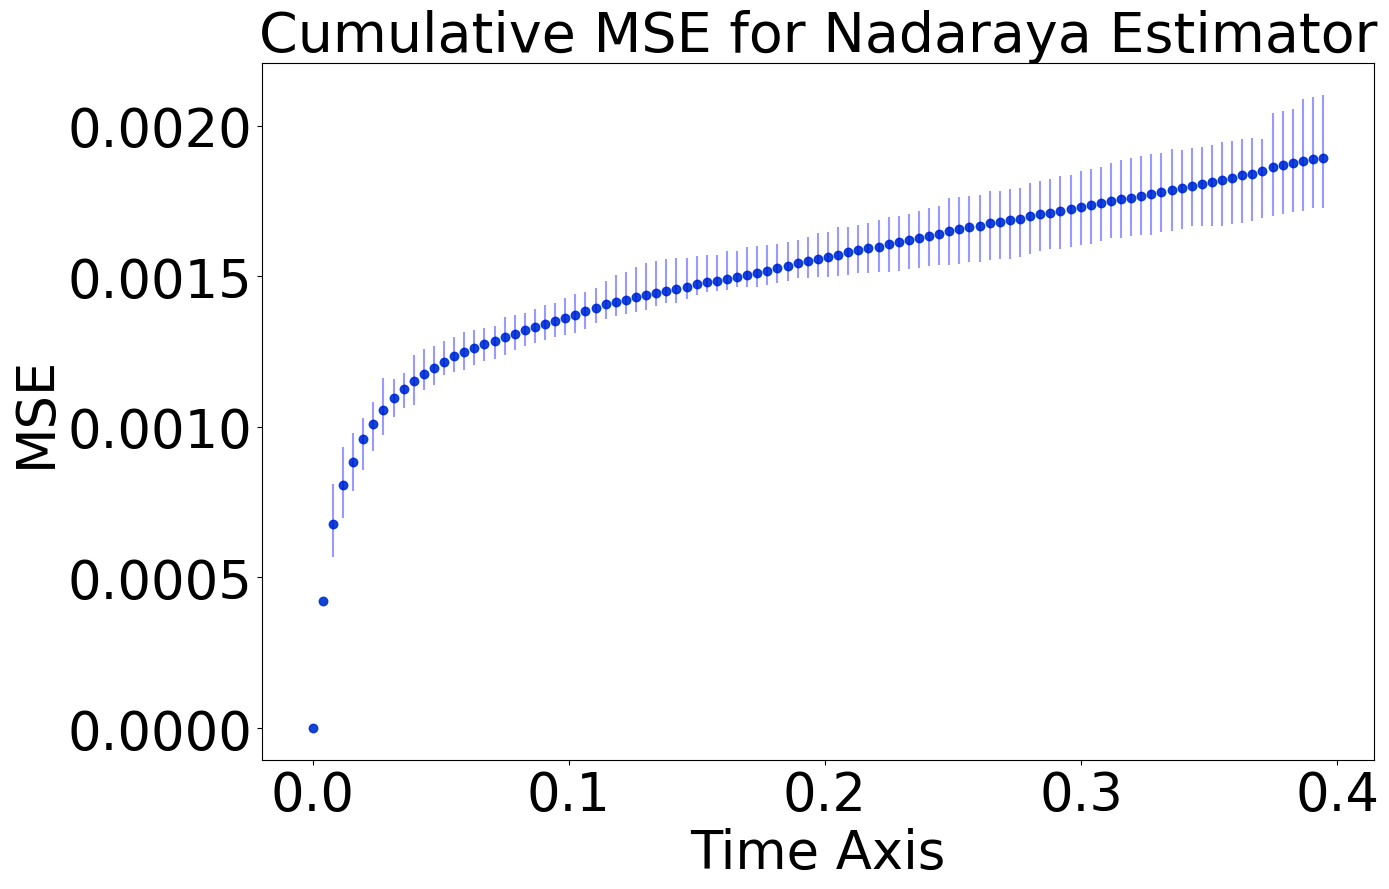

Final time cumulative MSE local-time error 0.0018937552615184076 with IQR ((0.0017284619362759285, 0.0021031827450000216))at bw 1.26e-05

0.0014935235357366743 0.00024290066386078155 0.0018937552615184076 2


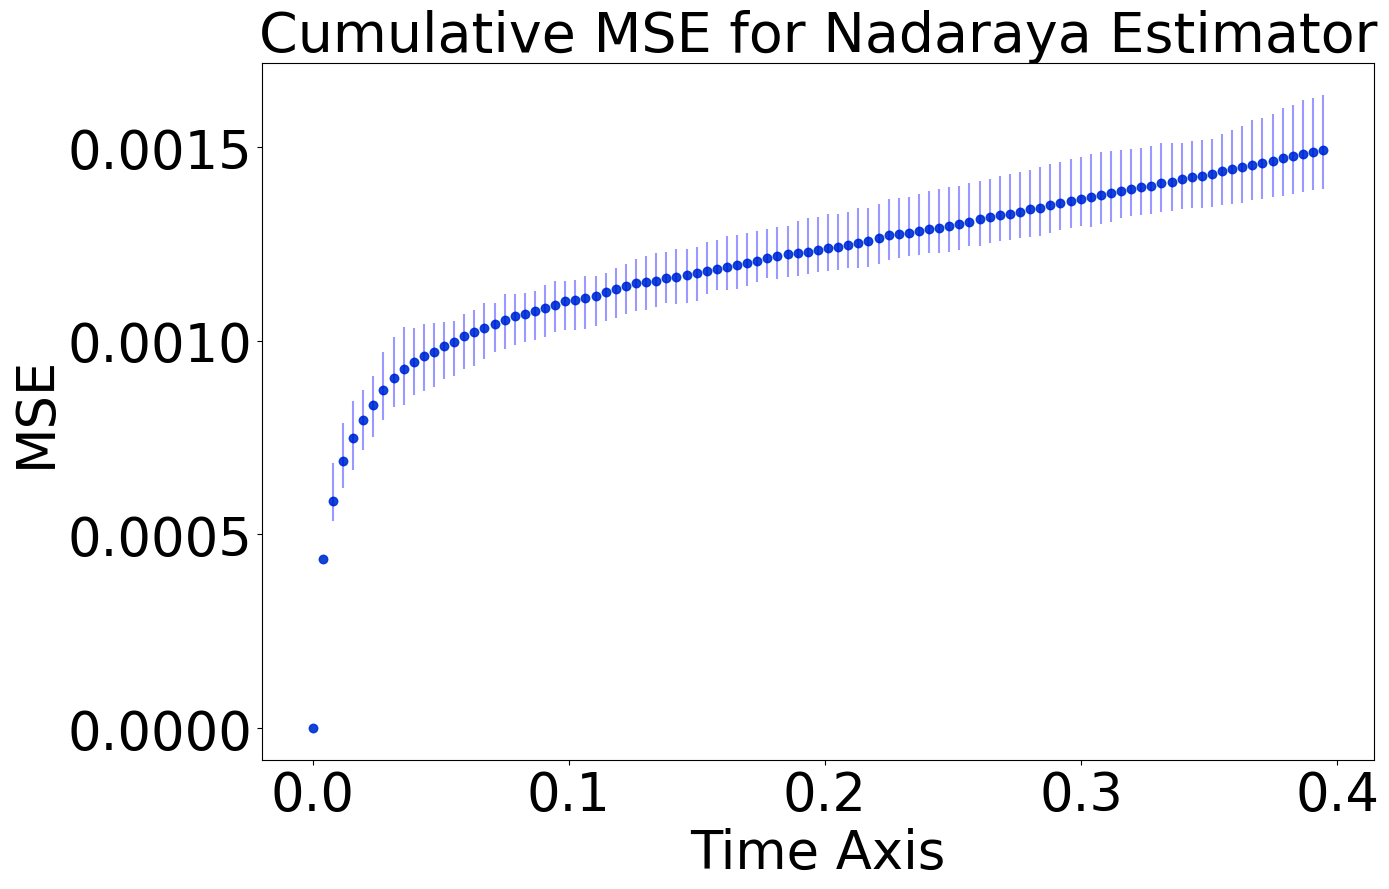

Final time cumulative MSE local-time error 0.0014935235357366743 with IQR ((0.0013931556126149274, 0.001636056276475709))at bw 1.59e-05

0.001223270786308388 0.0004314944262526698 0.0014935235357366743 3


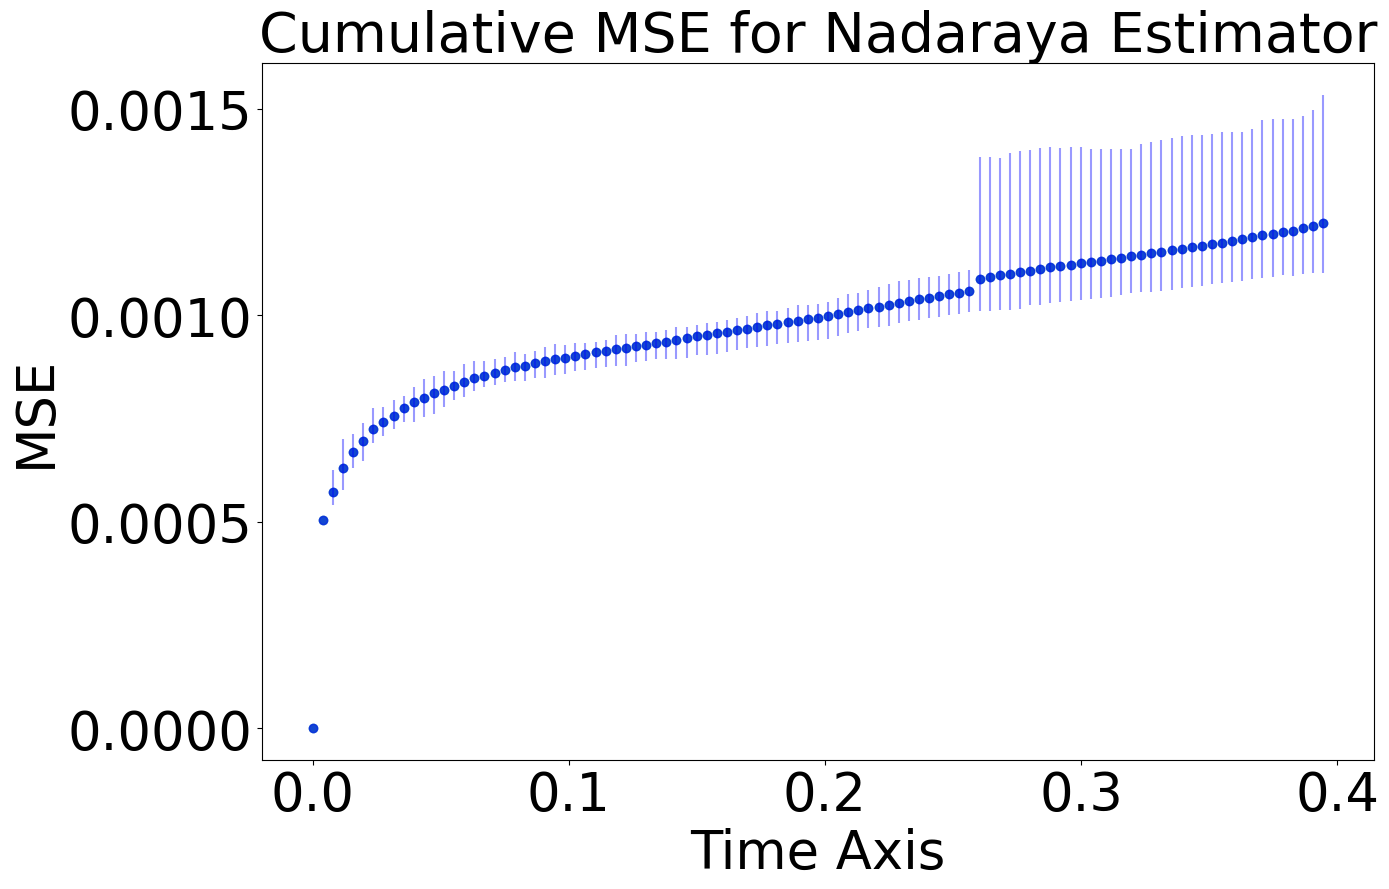

Final time cumulative MSE local-time error 0.001223270786308388 with IQR ((0.0011029254000535138, 0.0015344198263061836))at bw 2.01e-05

0.0009727607154810669 0.00016241925954012476 0.001223270786308388 4


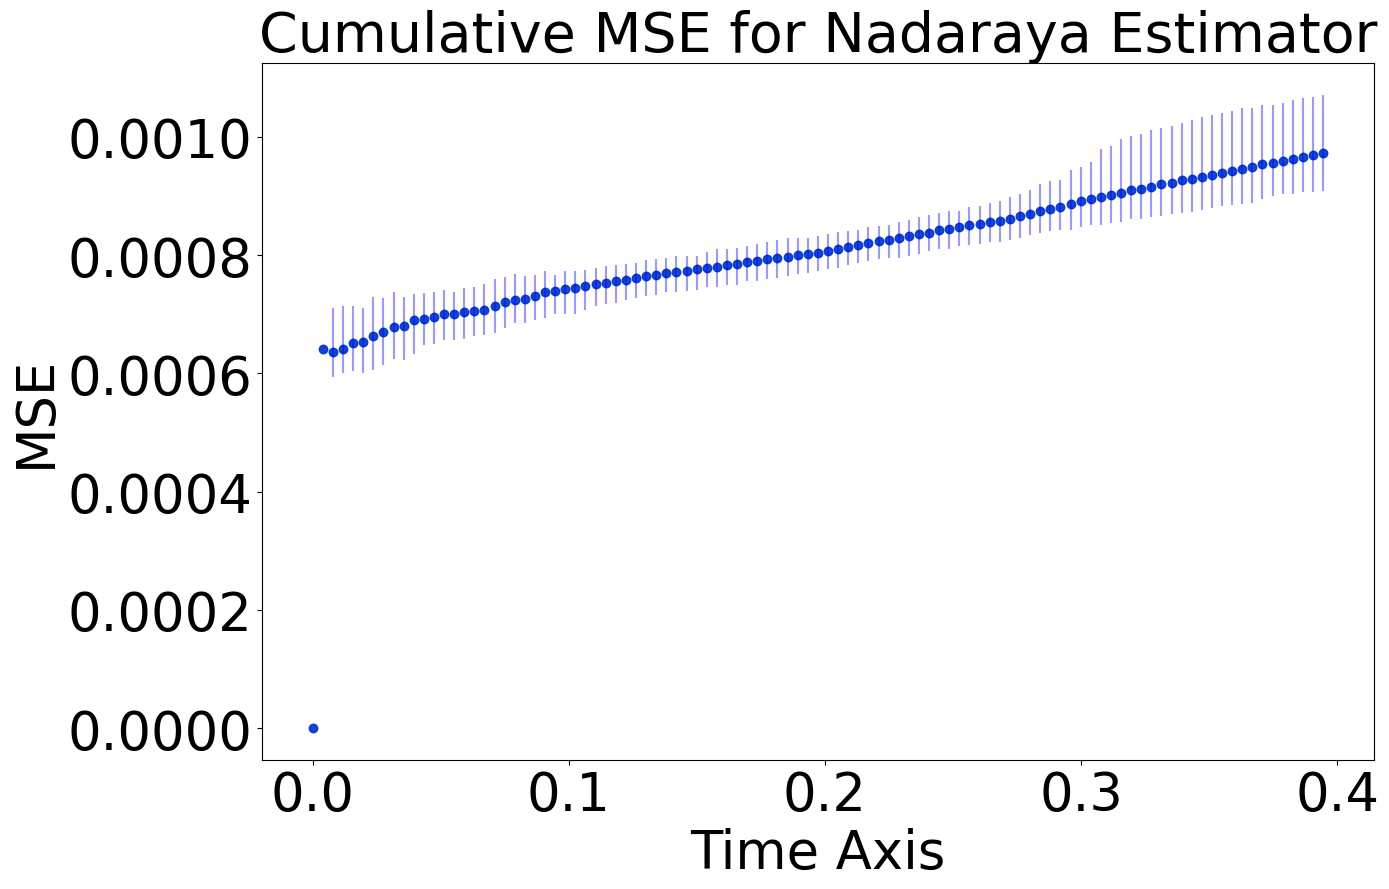

Final time cumulative MSE local-time error 0.0009727607154810669 with IQR ((0.0009090823735640362, 0.001071501633104161))at bw 2.54e-05

0.0007817130785842017 0.0001588753900544081 0.0009727607154810669 5


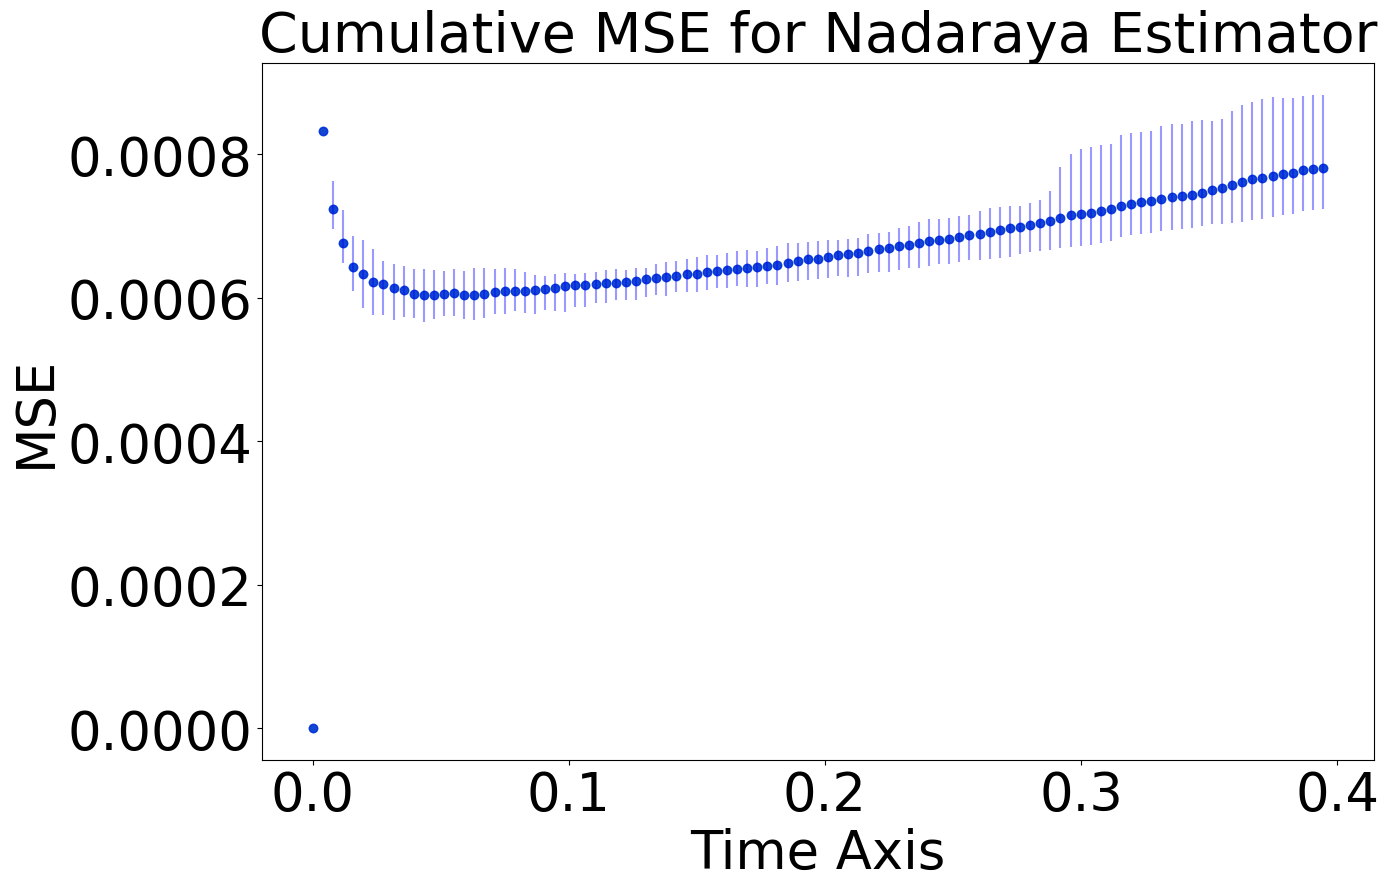

Final time cumulative MSE local-time error 0.0007817130785842017 with IQR ((0.0007244880663806658, 0.000883363456435074))at bw 3.21e-05

0.0006261011507974516 0.00013292800598939142 0.0007817130785842017 6


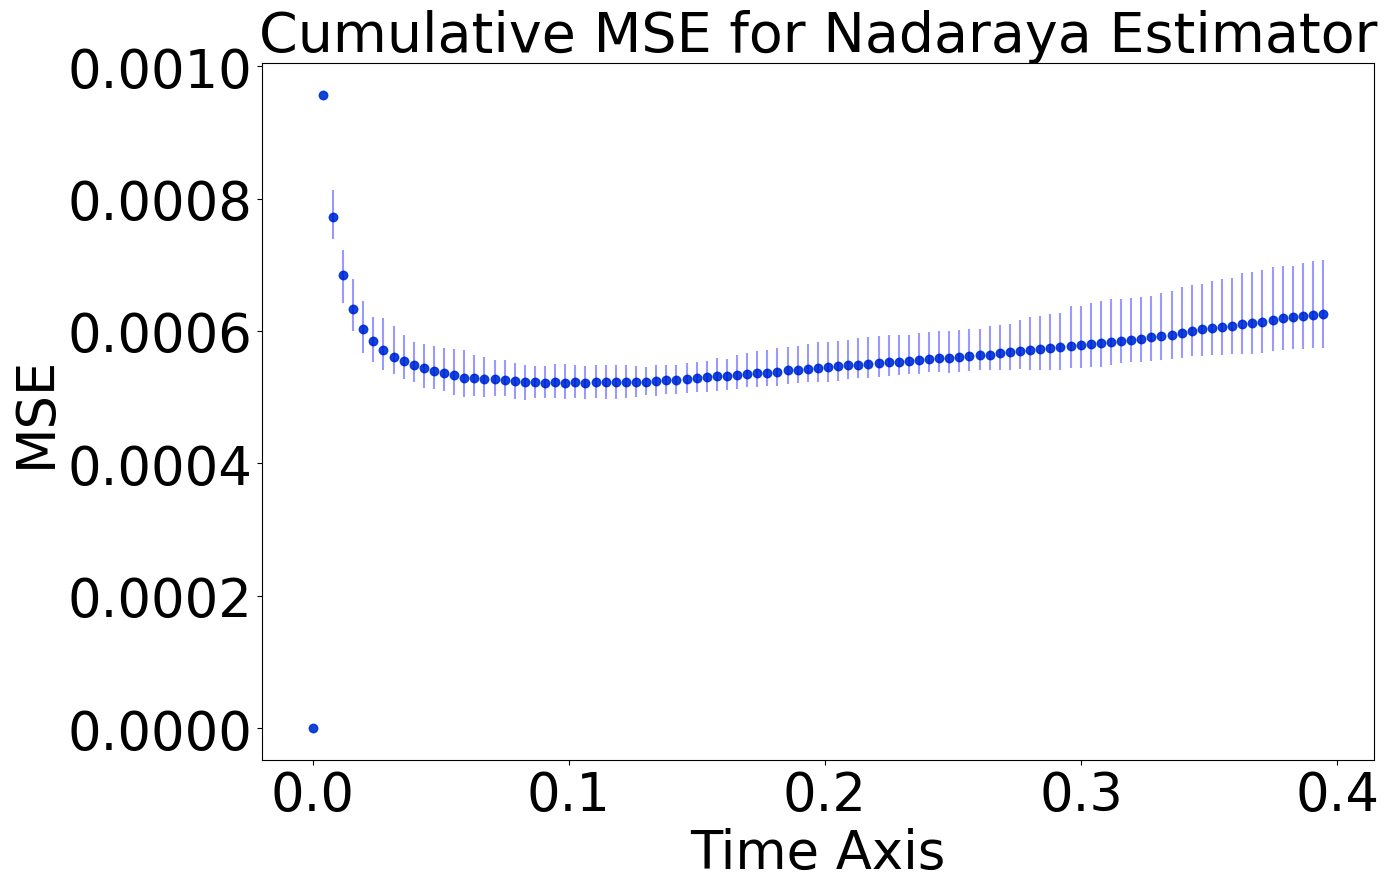

Final time cumulative MSE local-time error 0.0006261011507974516 with IQR ((0.000574155165400114, 0.0007070831713895054))at bw 4.05e-05

0.0004995943624223956 6.320469188602159e-05 0.0006261011507974516 7


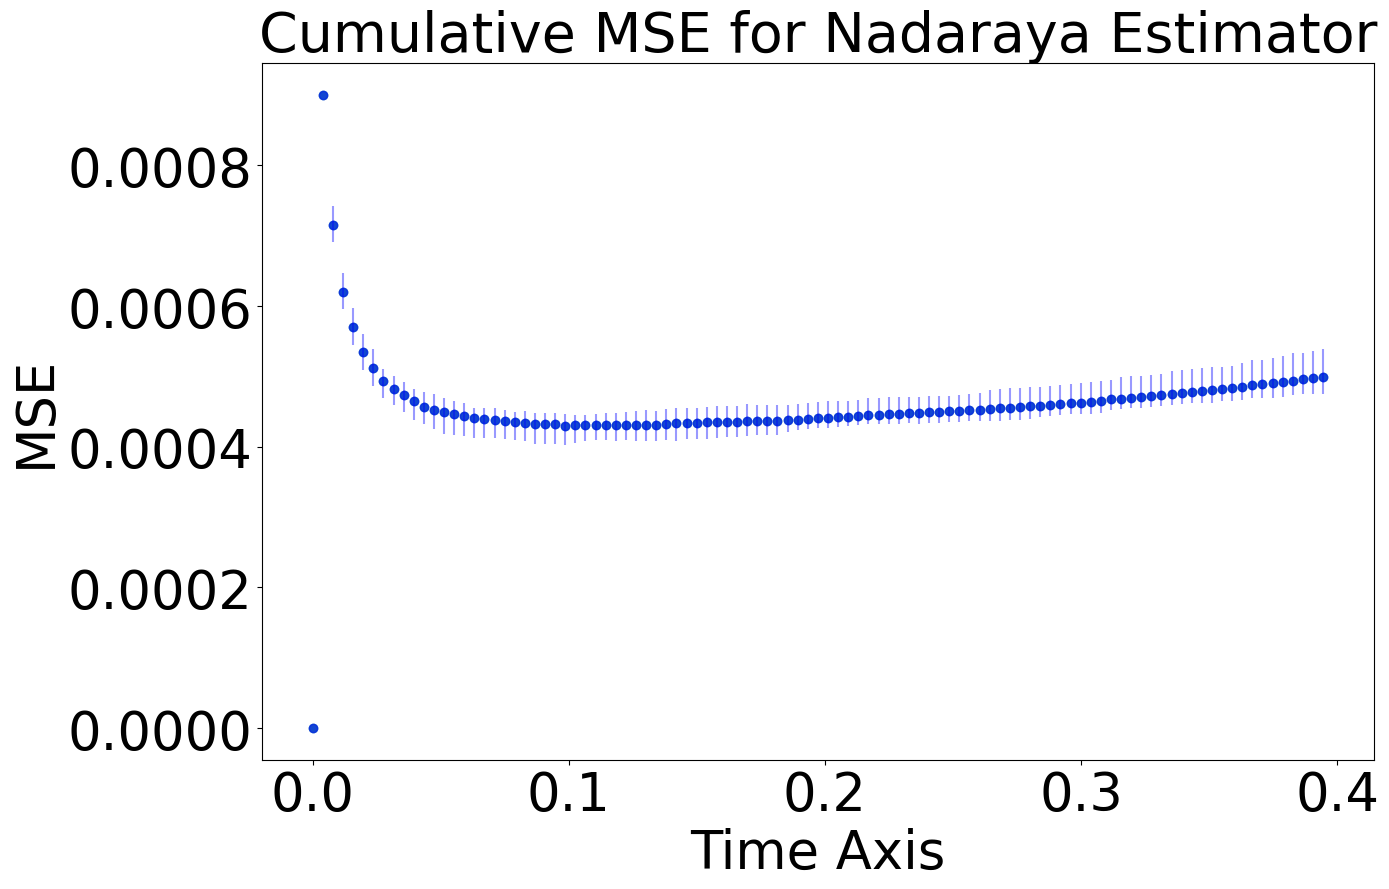

Final time cumulative MSE local-time error 0.0004995943624223956 with IQR ((0.00047539877935671315, 0.0005386034712427347))at bw 5.12e-05

0.0004171154601838328 0.00013597633254307603 0.0004995943624223956 8


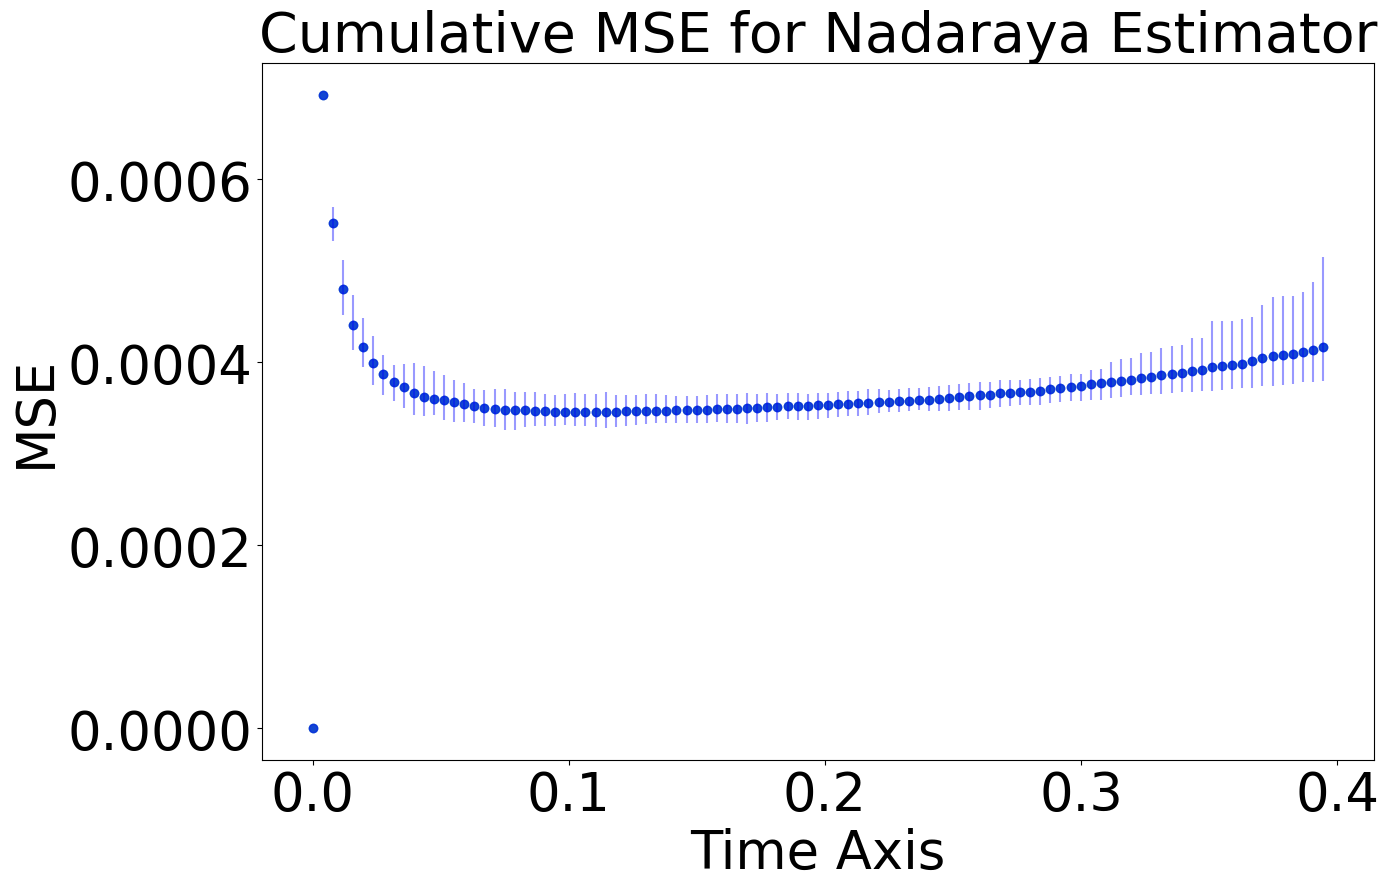

Final time cumulative MSE local-time error 0.0004171154601838328 with IQR ((0.00037918769846577075, 0.0005151640310088468))at bw 6.46e-05

0.0003391199789216686 0.0001309204539929922 0.0004171154601838328 9


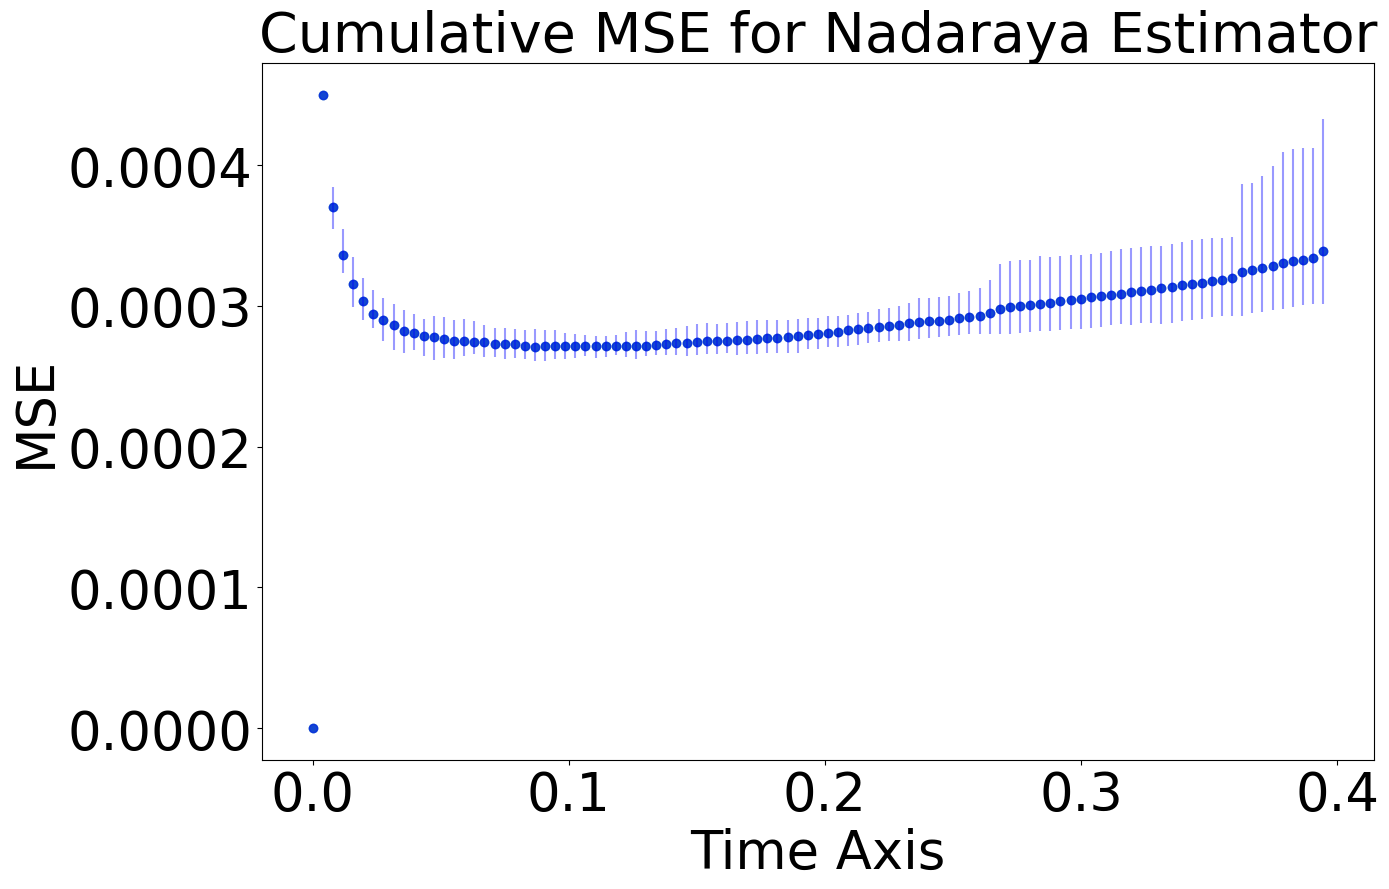

Final time cumulative MSE local-time error 0.0003391199789216686 with IQR ((0.000301642114343534, 0.0004325625683365262))at bw 8.16e-05

0.0002591458301546548 5.230852299997169e-05 0.0003391199789216686 10


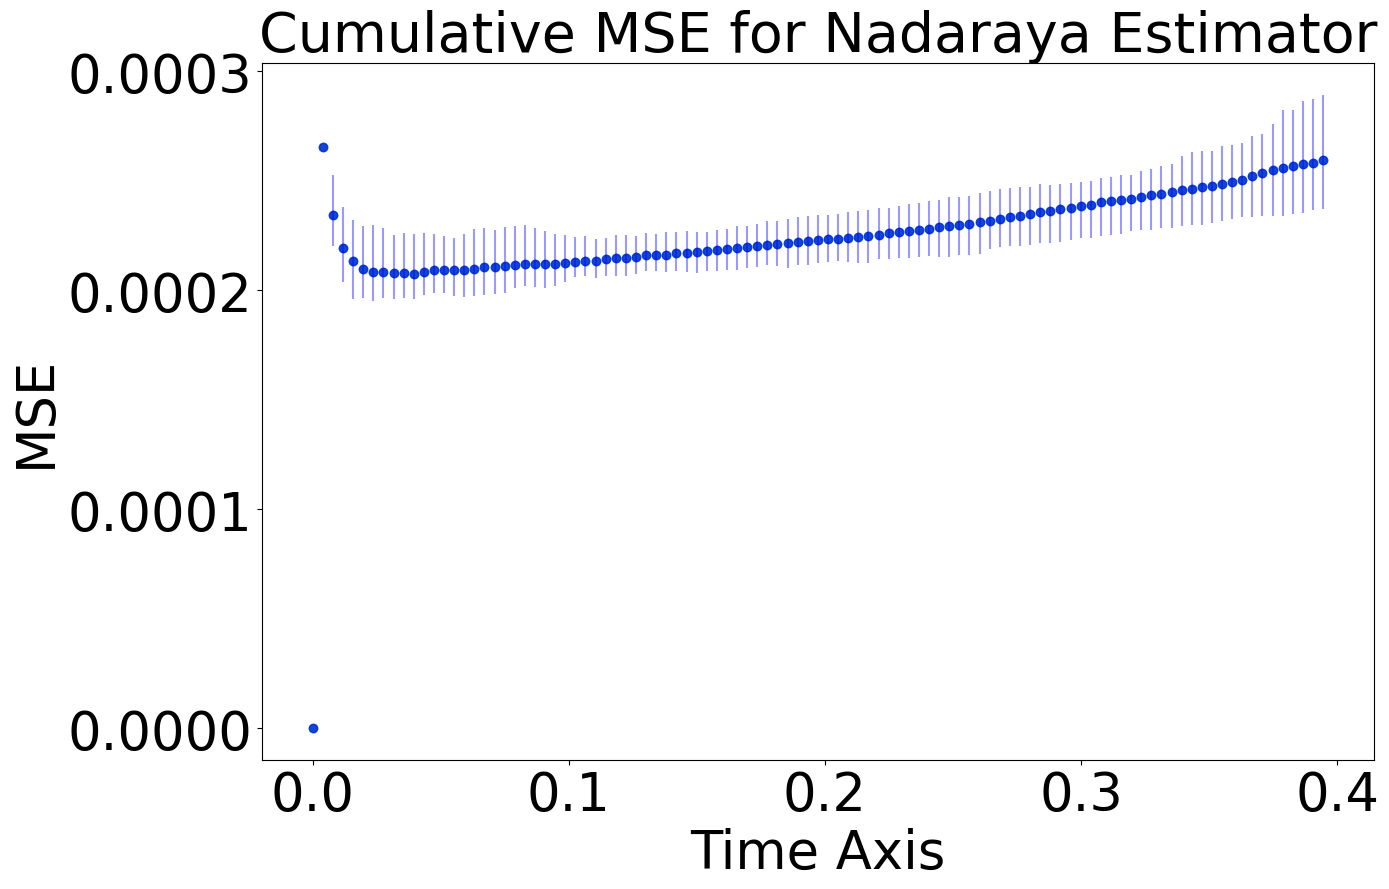

Final time cumulative MSE local-time error 0.0002591458301546548 with IQR ((0.00023689474633941442, 0.0002892032693393861))at bw 0.000103

0.00020861761390497685 5.431999754943926e-05 0.0002591458301546548 11


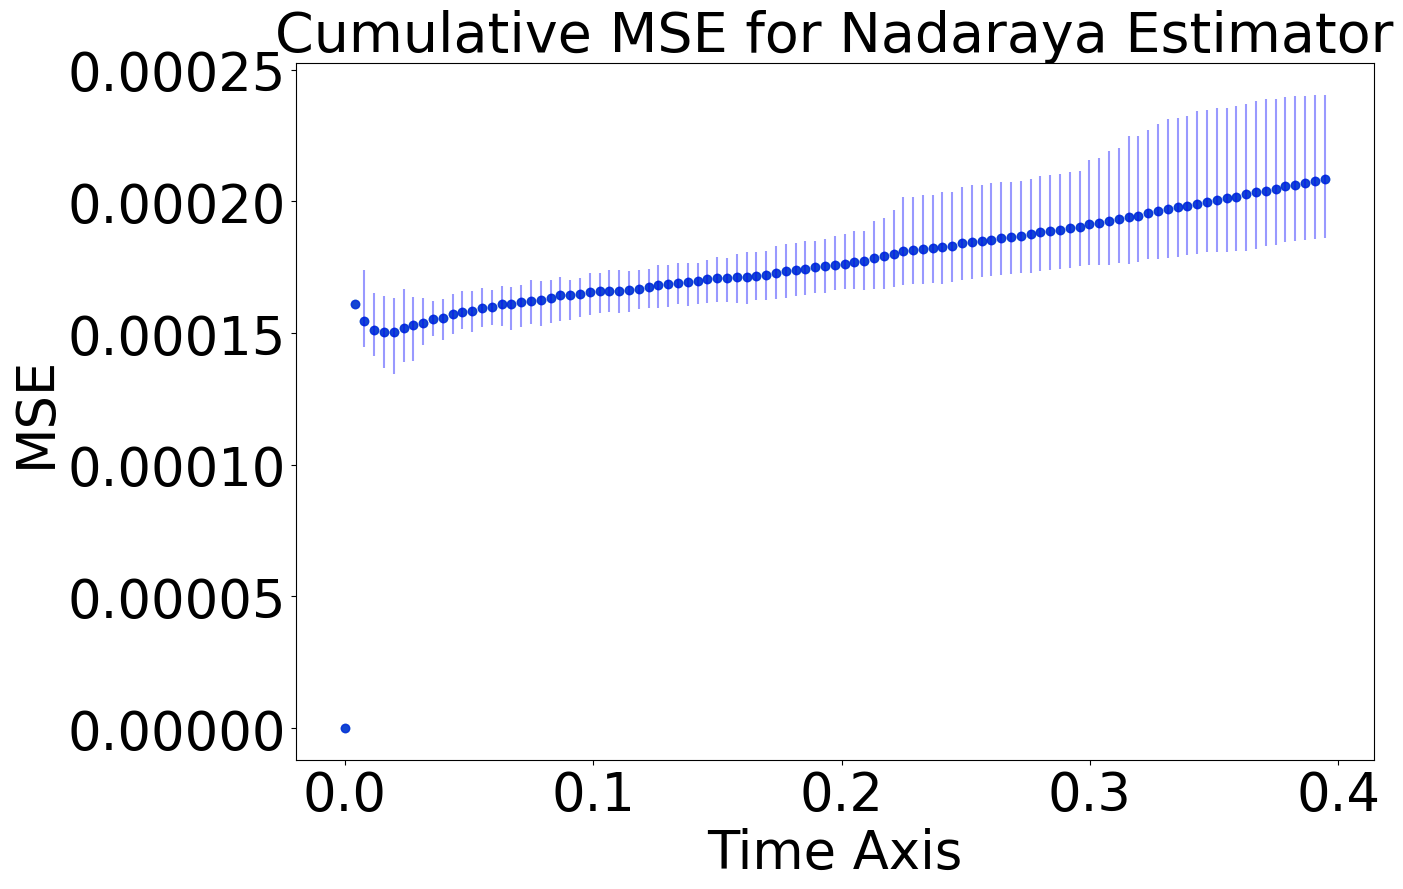

Final time cumulative MSE local-time error 0.00020861761390497685 with IQR ((0.00018614767030615976, 0.00024046766785559902))at bw 0.00013

0.00016076387231902335 3.129787648332432e-05 0.00020861761390497685 12


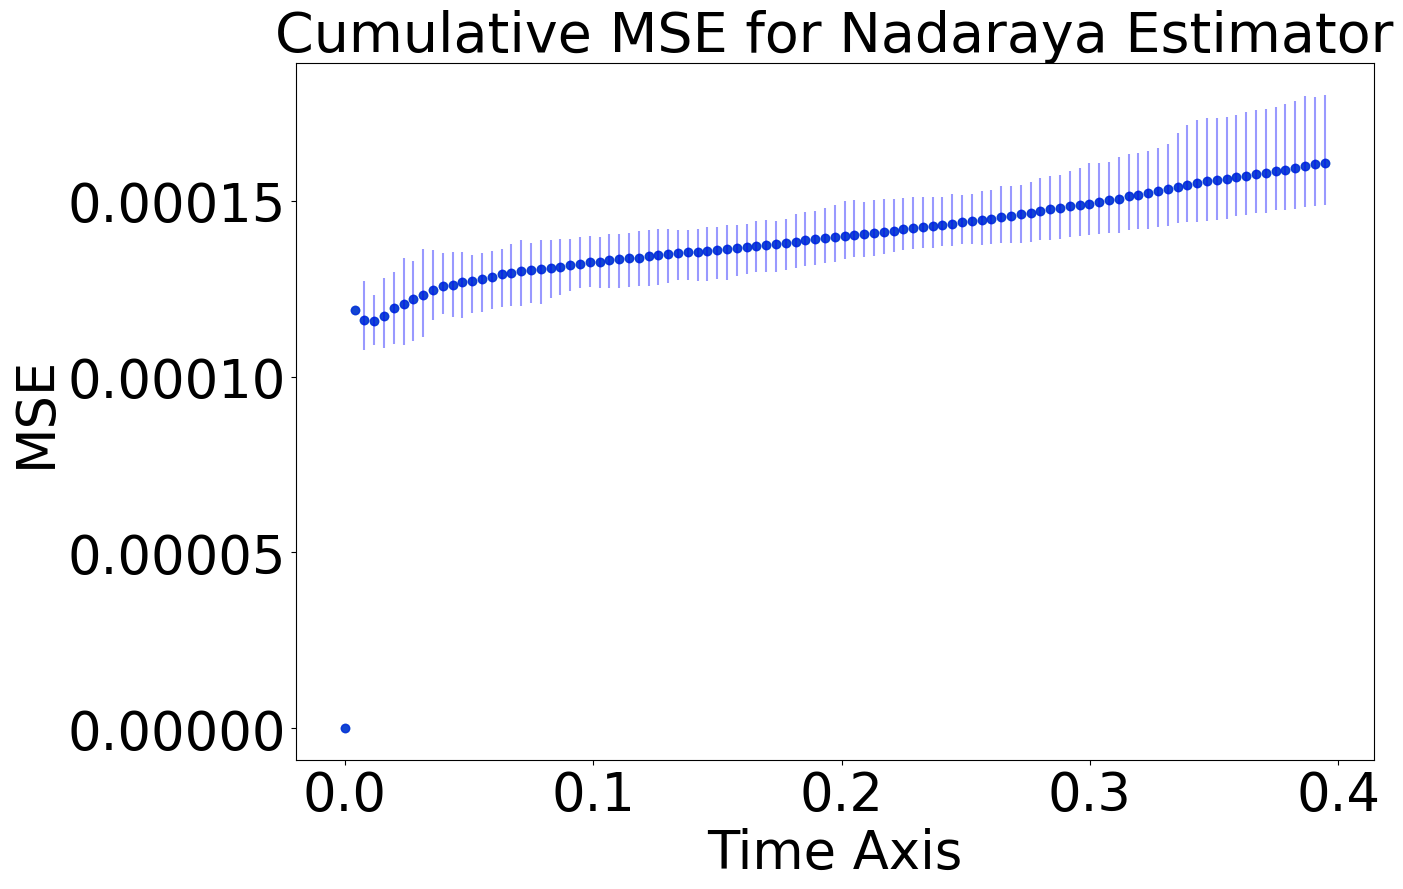

Final time cumulative MSE local-time error 0.00016076387231902335 with IQR ((0.0001488851925098205, 0.00018018306899314482))at bw 0.0001642

0.00013007020626290203 1.8205625208890226e-05 0.00016076387231902335 13


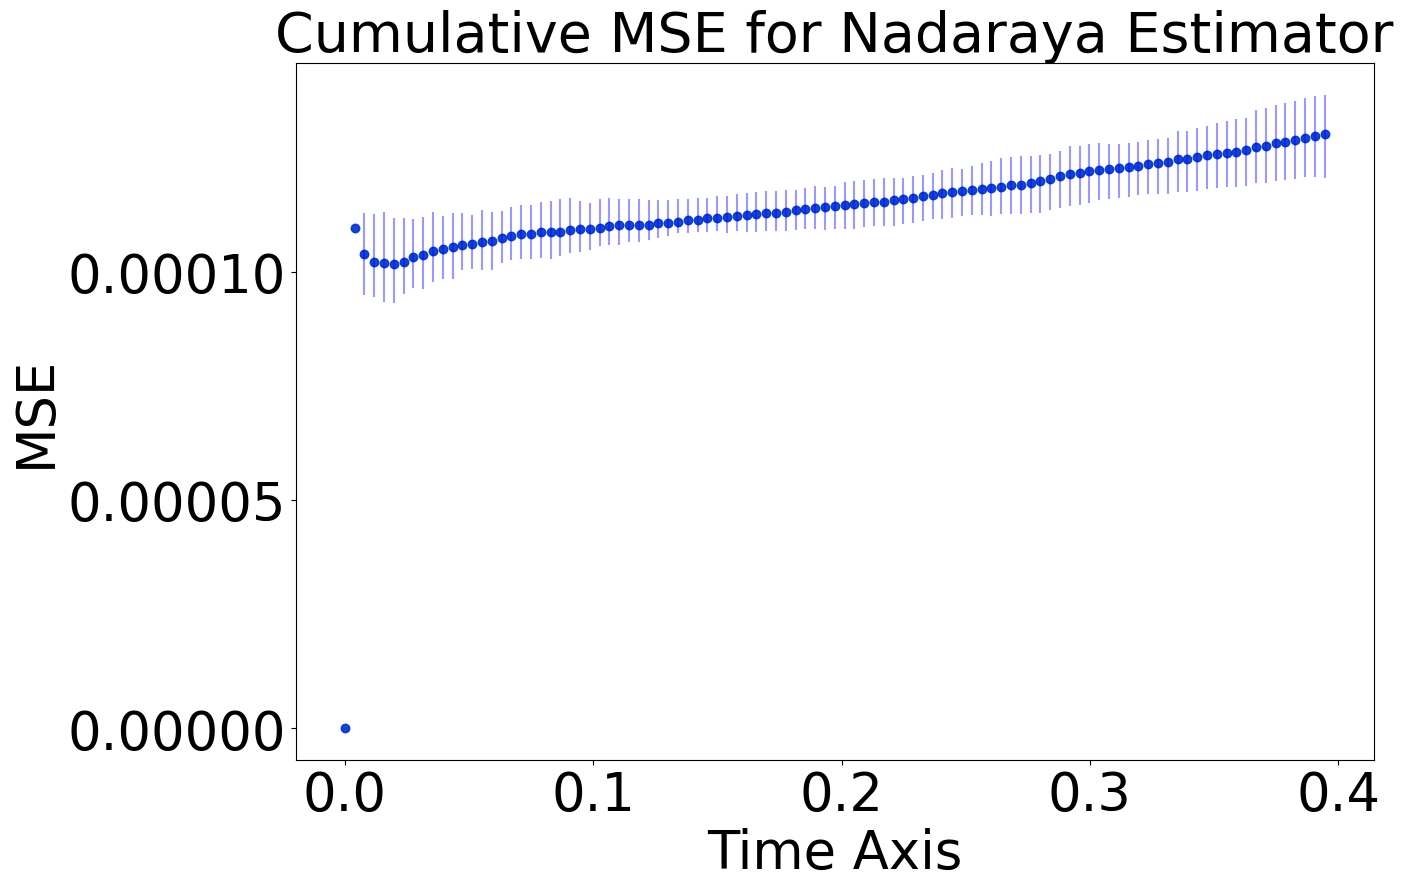

Final time cumulative MSE local-time error 0.00013007020626290203 with IQR ((0.00012058243766931671, 0.00013878806287820694))at bw 0.0002073

0.00010588358783912395 2.3875286951545558e-05 0.00013007020626290203 14


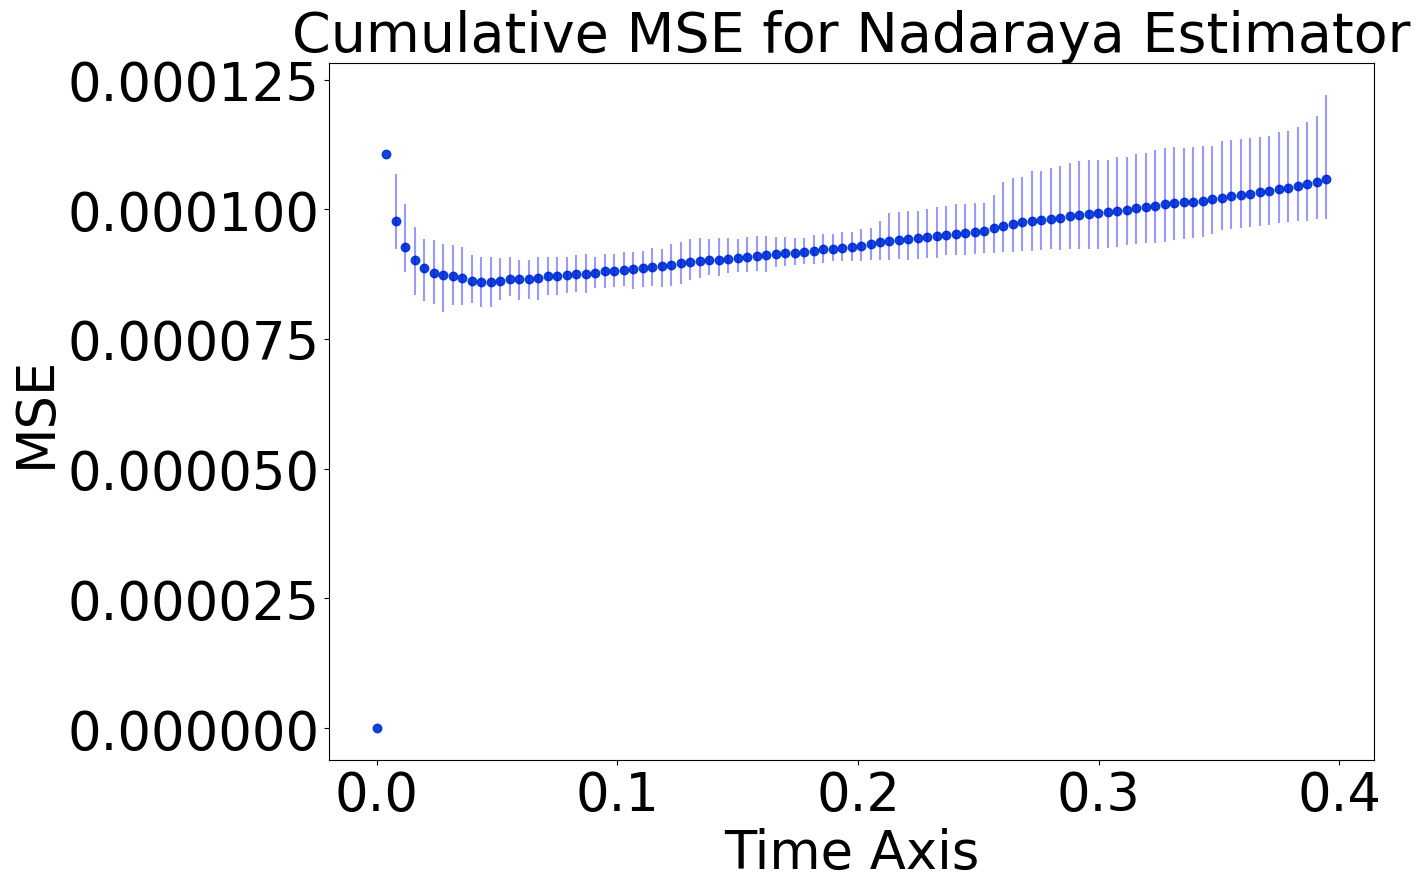

Final time cumulative MSE local-time error 0.00010588358783912395 with IQR ((9.822225019731257e-05, 0.00012209753714885813))at bw 0.0002618

8.93224060614657e-05 2.5725481436736887e-05 0.00010588358783912395 15


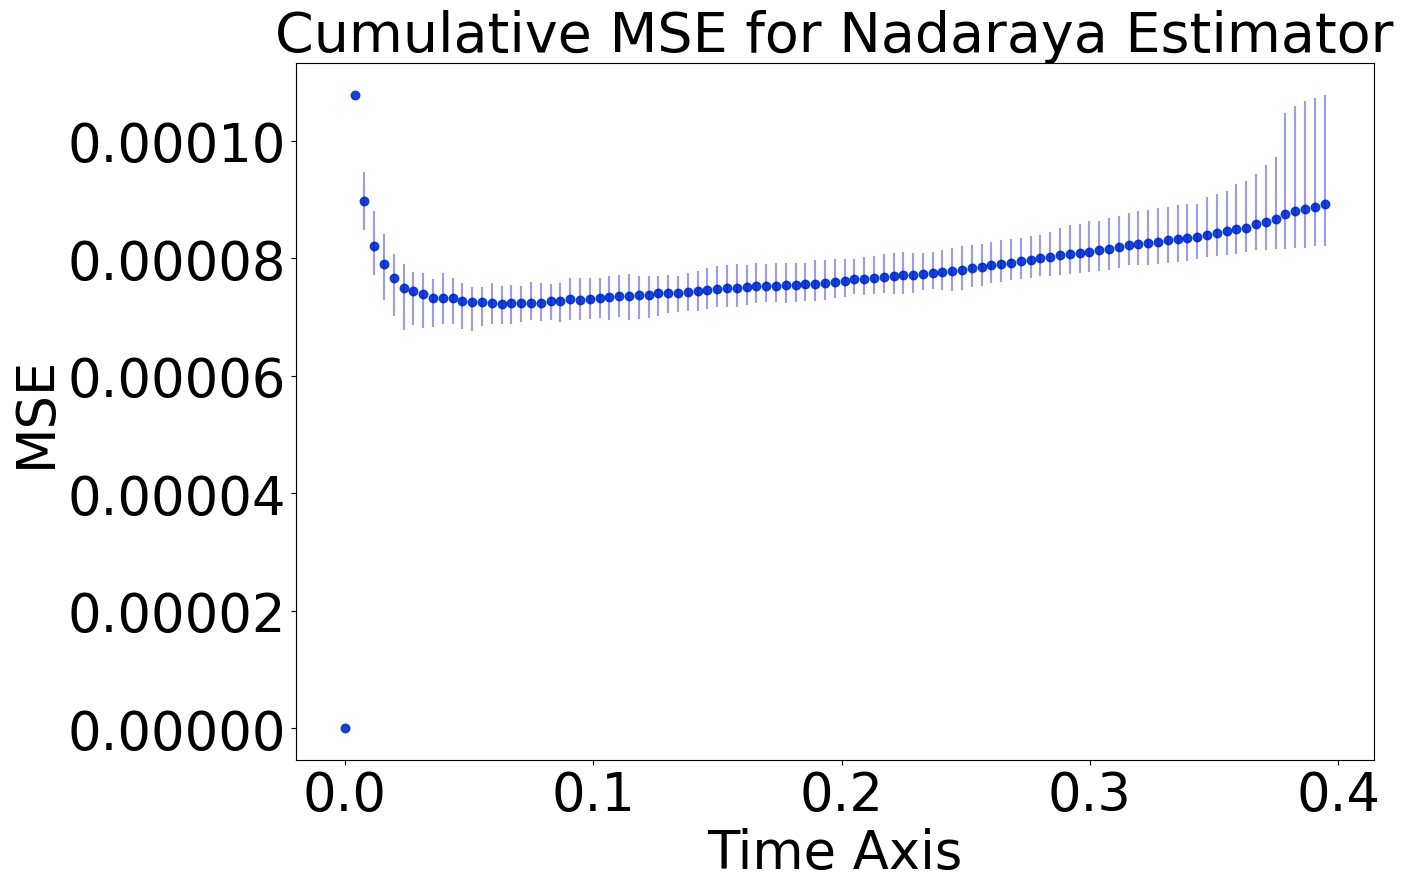

Final time cumulative MSE local-time error 8.93224060614657e-05 with IQR ((8.214496572007287e-05, 0.00010787044715680976))at bw 0.0003305

6.945188098365438e-05 1.6743776637176958e-05 8.93224060614657e-05 16


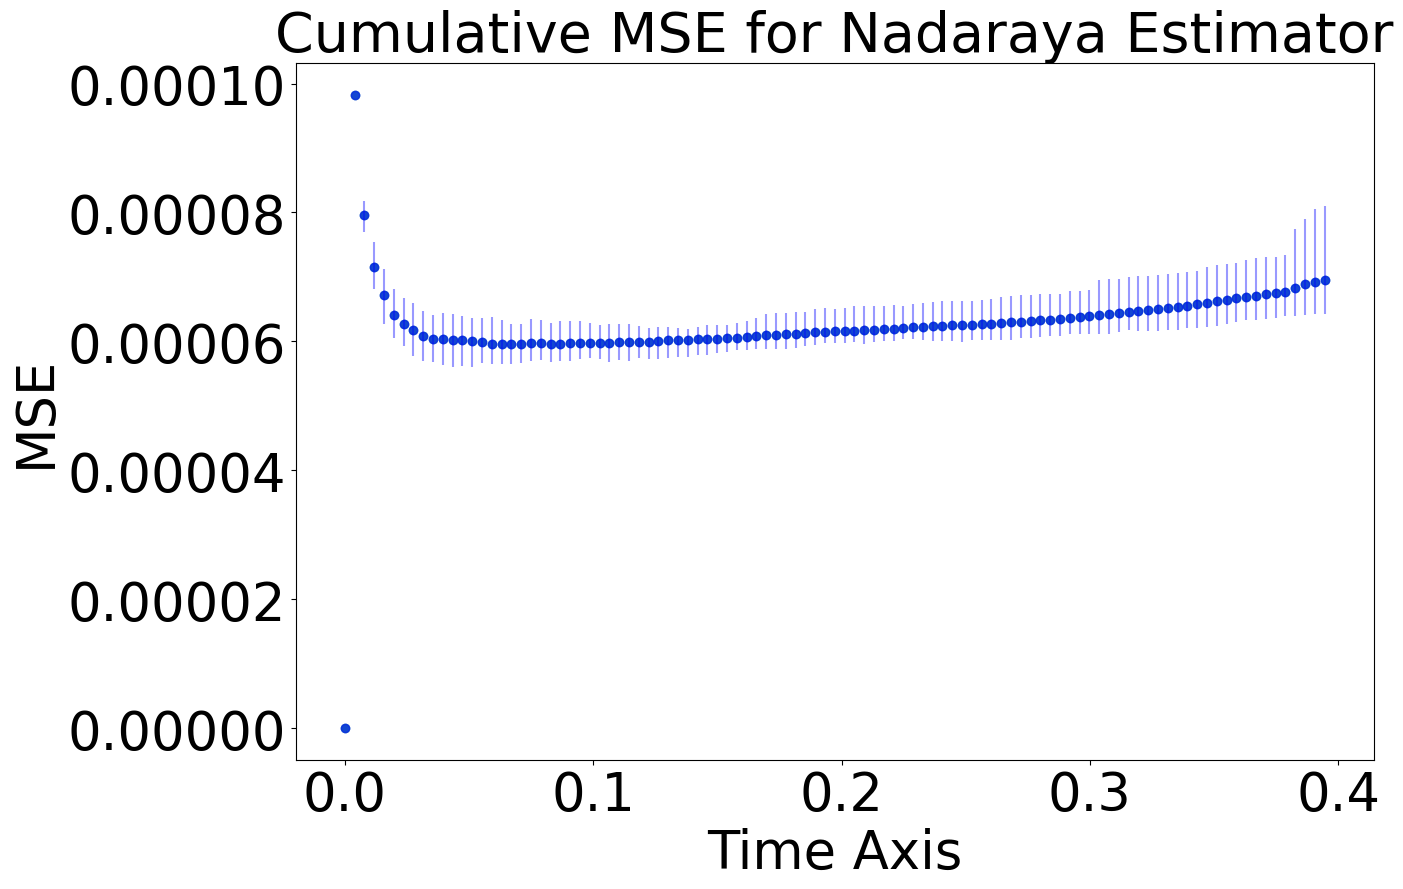

Final time cumulative MSE local-time error 6.945188098365438e-05 with IQR ((6.431856582869712e-05, 8.106234246587408e-05))at bw 0.0004174

5.903504103313822e-05 3.202145746777833e-05 6.945188098365438e-05 17


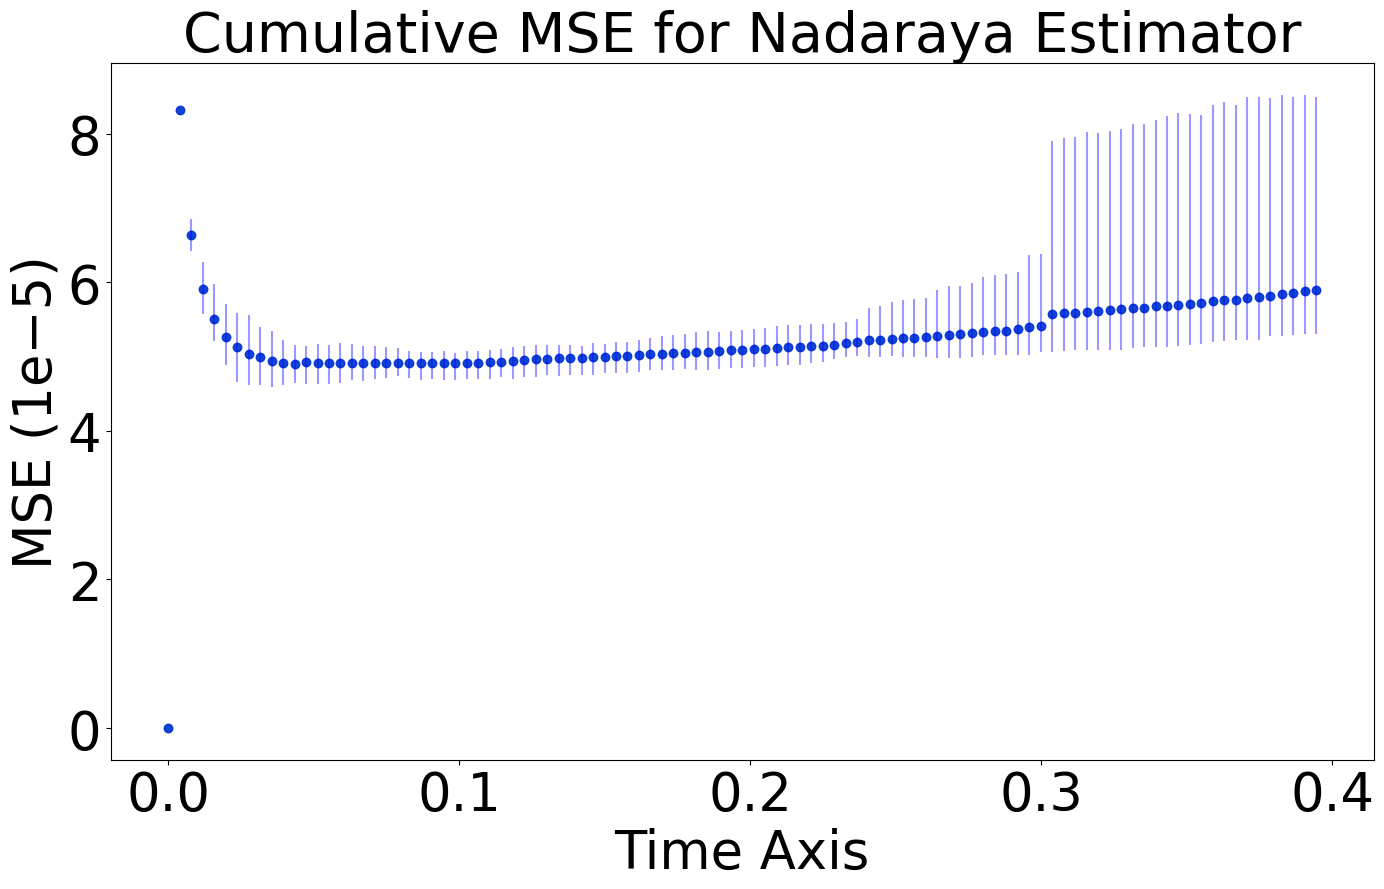

Final time cumulative MSE local-time error 5.903504103313822e-05 with IQR ((5.2989150897151854e-05, 8.501060836493018e-05))at bw 0.000527

4.587371374378766e-05 2.0103169448993628e-05 5.903504103313822e-05 18


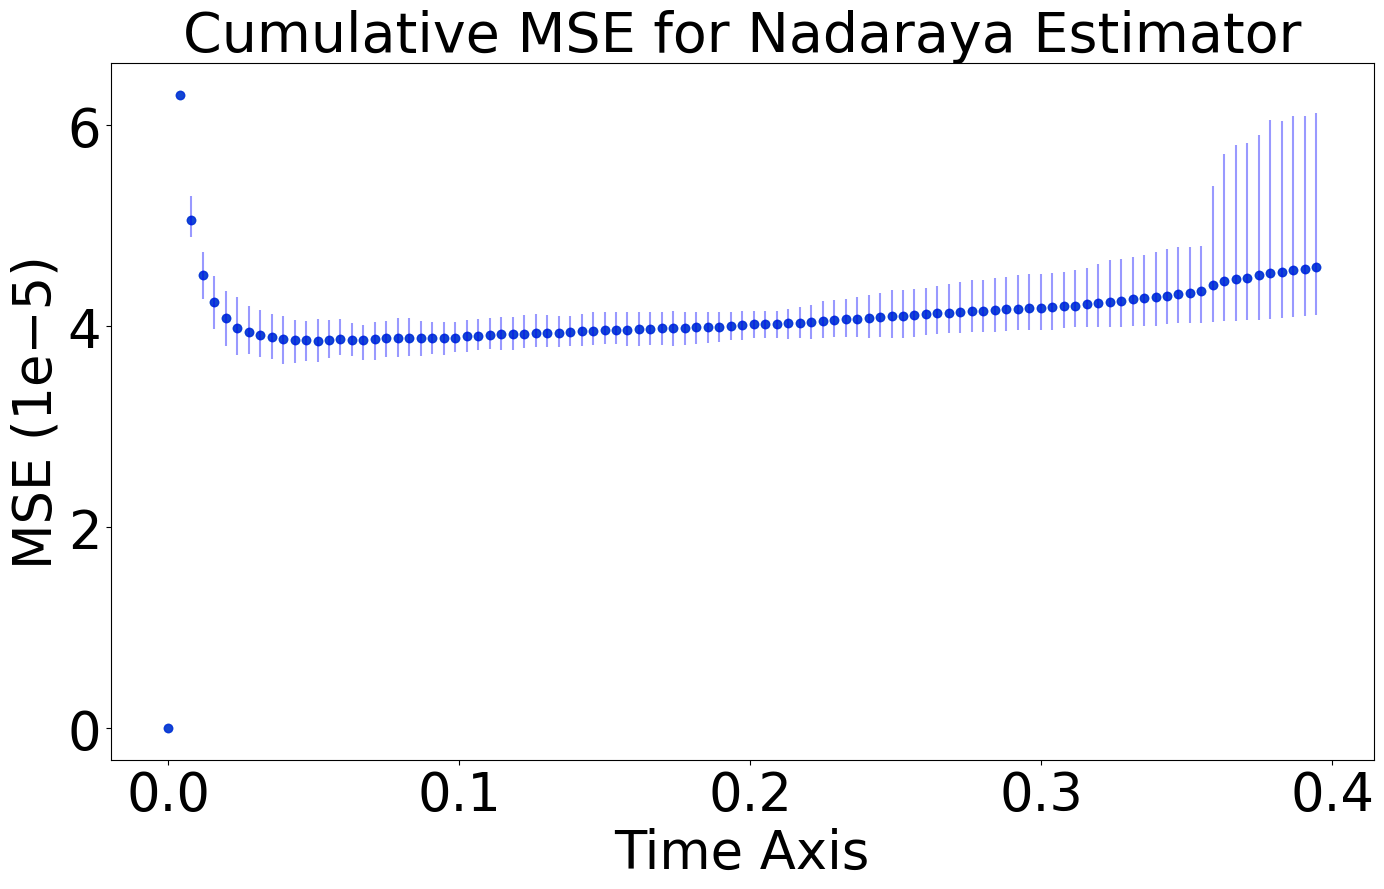

Final time cumulative MSE local-time error 4.587371374378766e-05 with IQR ((4.110251469003851e-05, 6.120568413903214e-05))at bw 0.0006654

3.52069194909071e-05 1.226400155989535e-05 4.587371374378766e-05 19


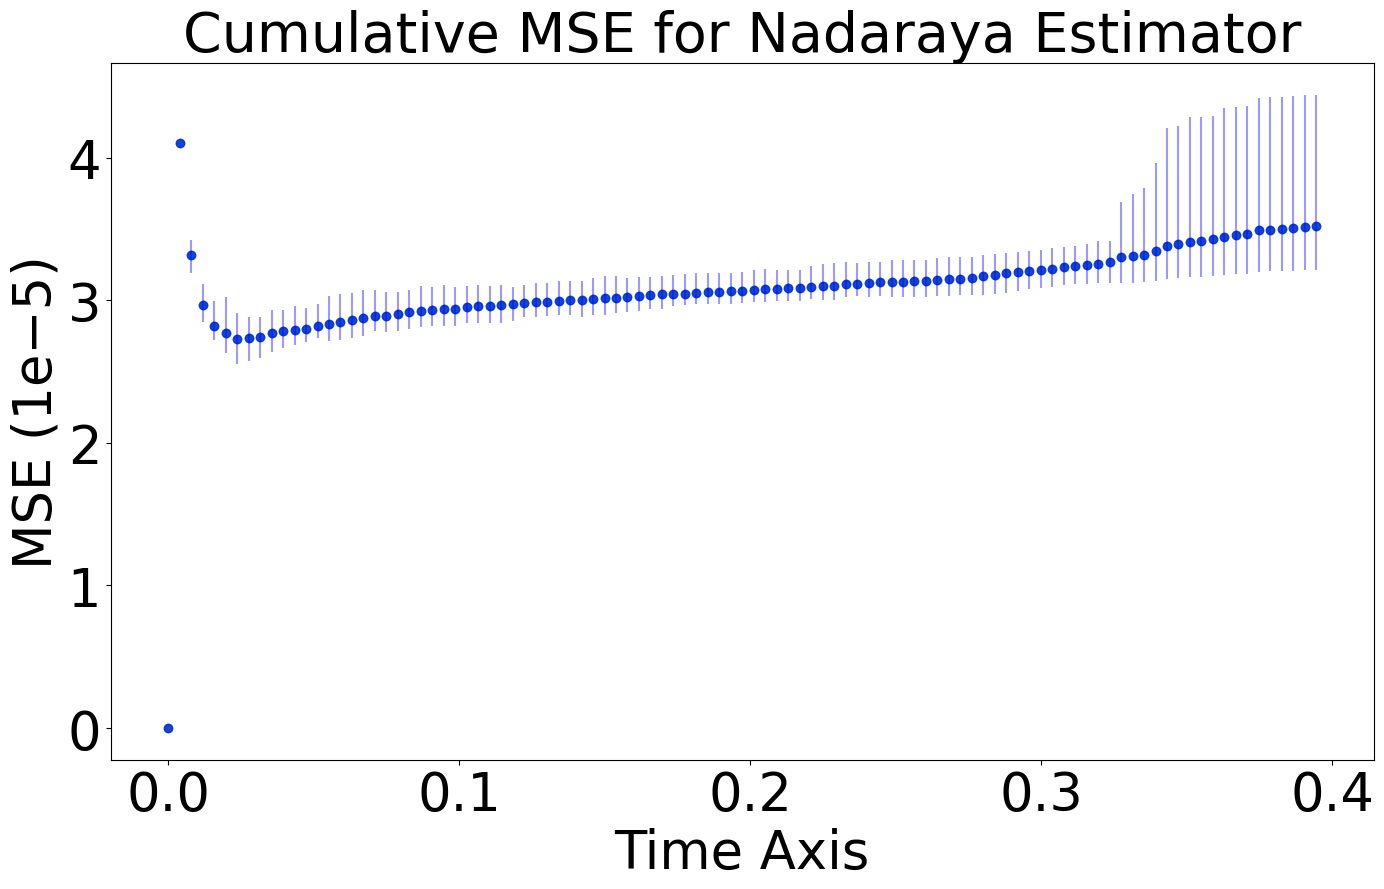

Final time cumulative MSE local-time error 3.52069194909071e-05 with IQR ((3.215997124623427e-05, 4.442397280612962e-05))at bw 0.0008402

2.597004677189764e-05 4.707830868079952e-06 3.52069194909071e-05 20


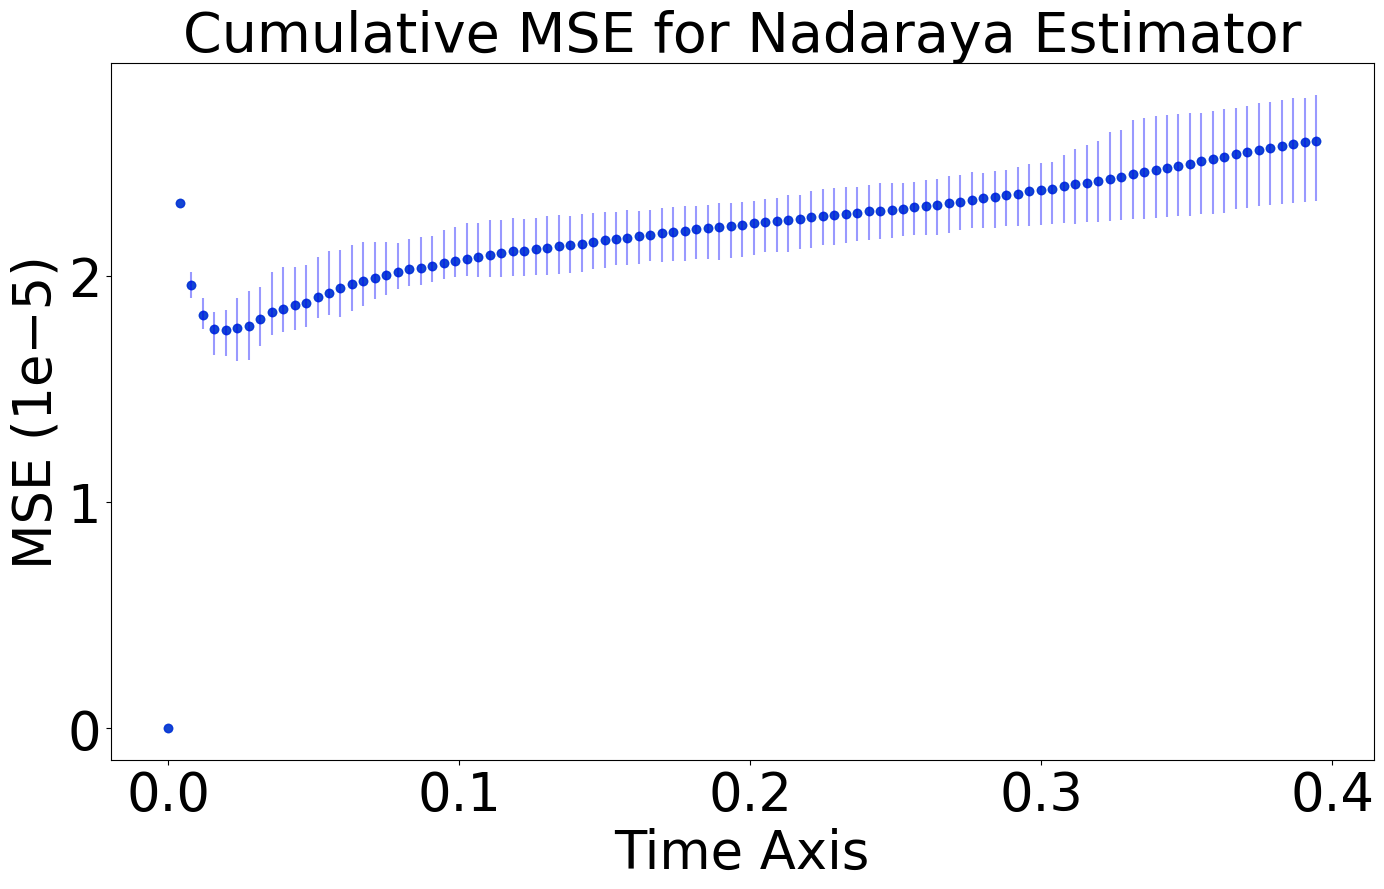

Final time cumulative MSE local-time error 2.597004677189764e-05 with IQR ((2.3288511067916924e-05, 2.7996341935996876e-05))at bw 0.0010608

1.8560318847009578e-05 2.297730250349548e-06 2.597004677189764e-05 21


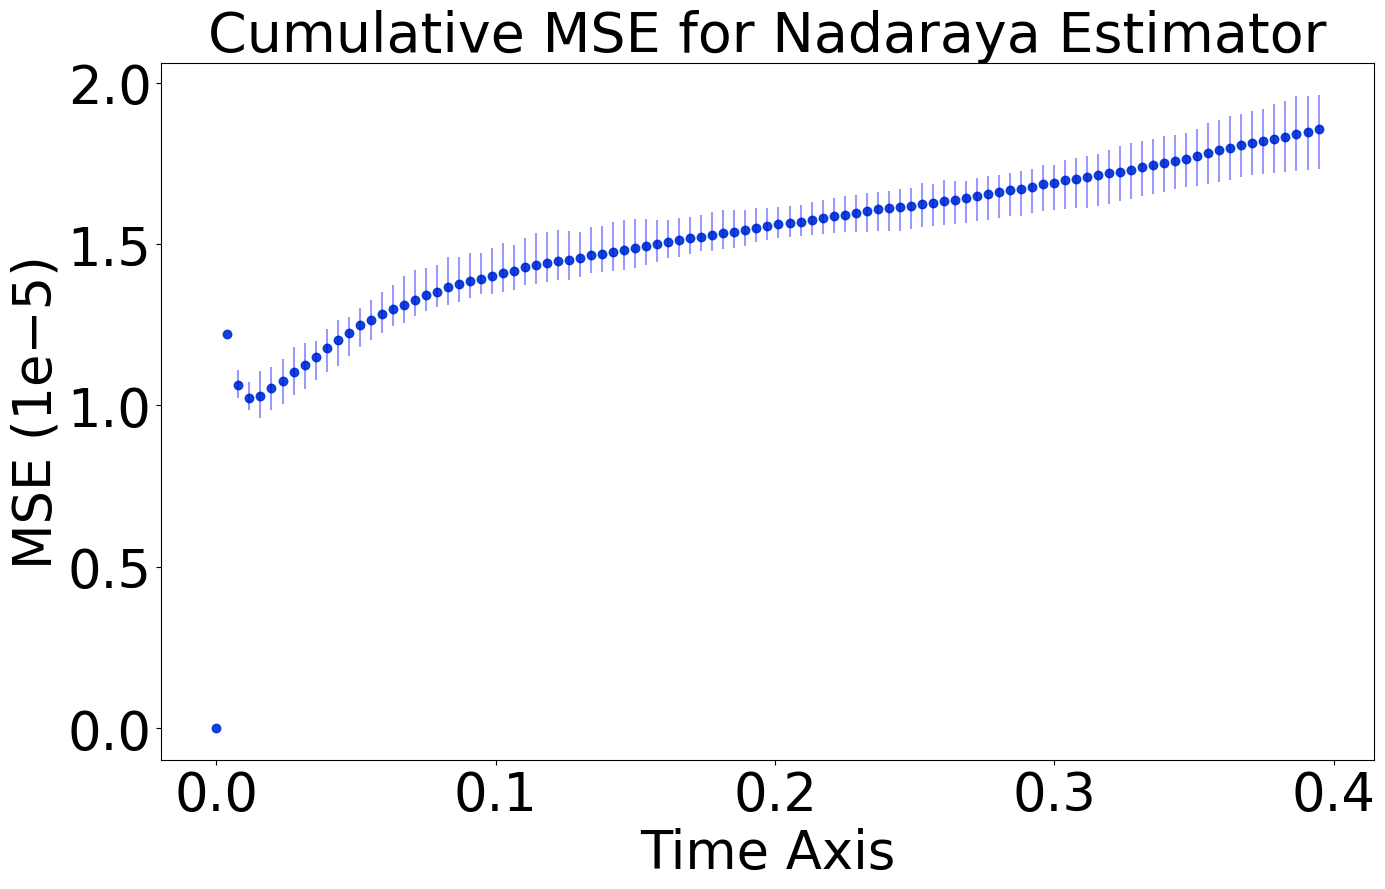

Final time cumulative MSE local-time error 1.8560318847009578e-05 with IQR ((1.7331382489193388e-05, 1.9629112739542936e-05))at bw 0.0013394

1.4097885131742099e-05 7.736390748930246e-06 1.8560318847009578e-05 22


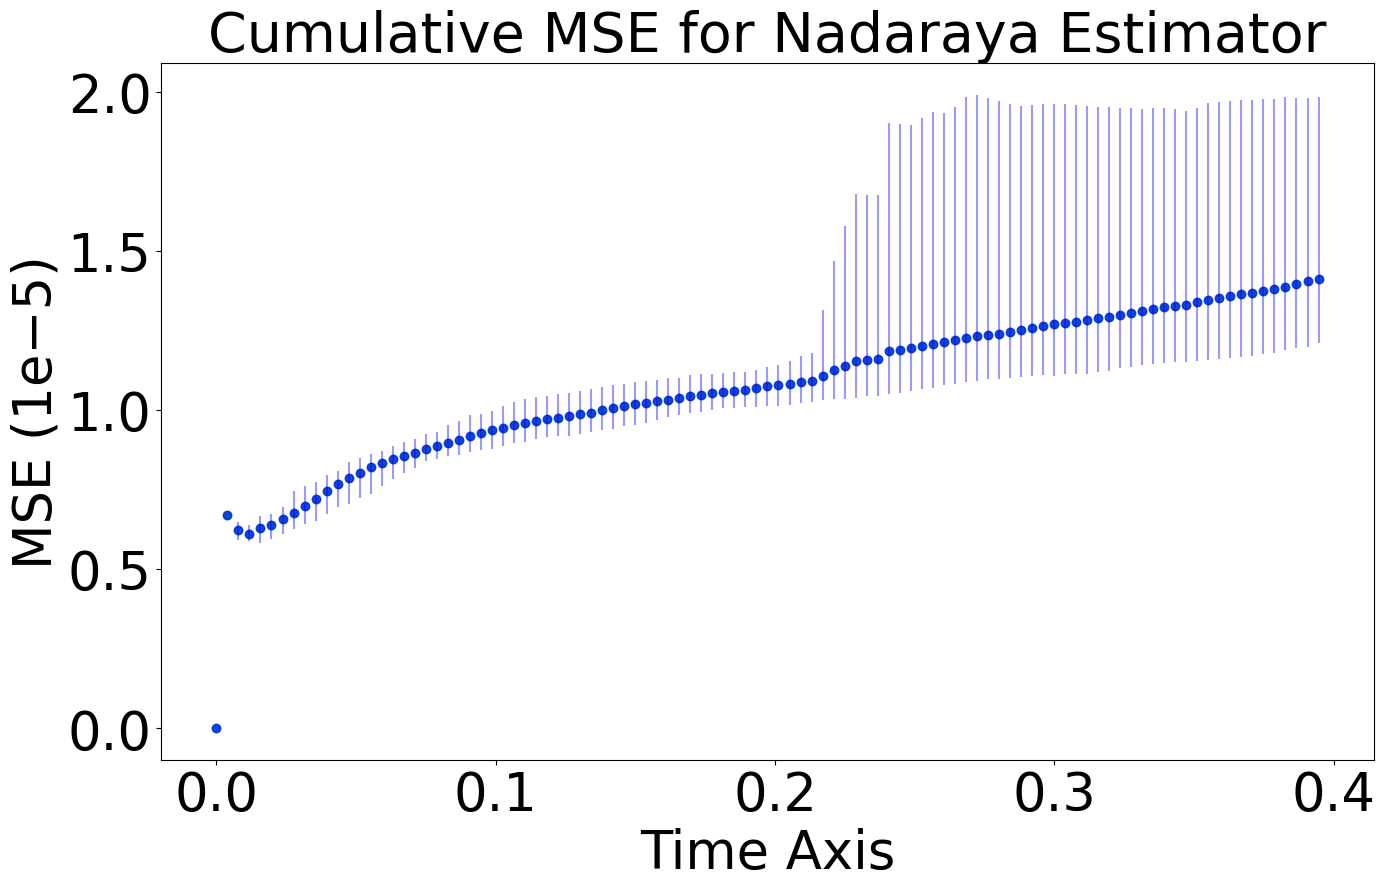

Final time cumulative MSE local-time error 1.4097885131742099e-05 with IQR ((1.209609428195349e-05, 1.9832485030883735e-05))at bw 0.0016912

1.3923035681190596e-05 4.4680372856651e-05 1.4097885131742099e-05 23


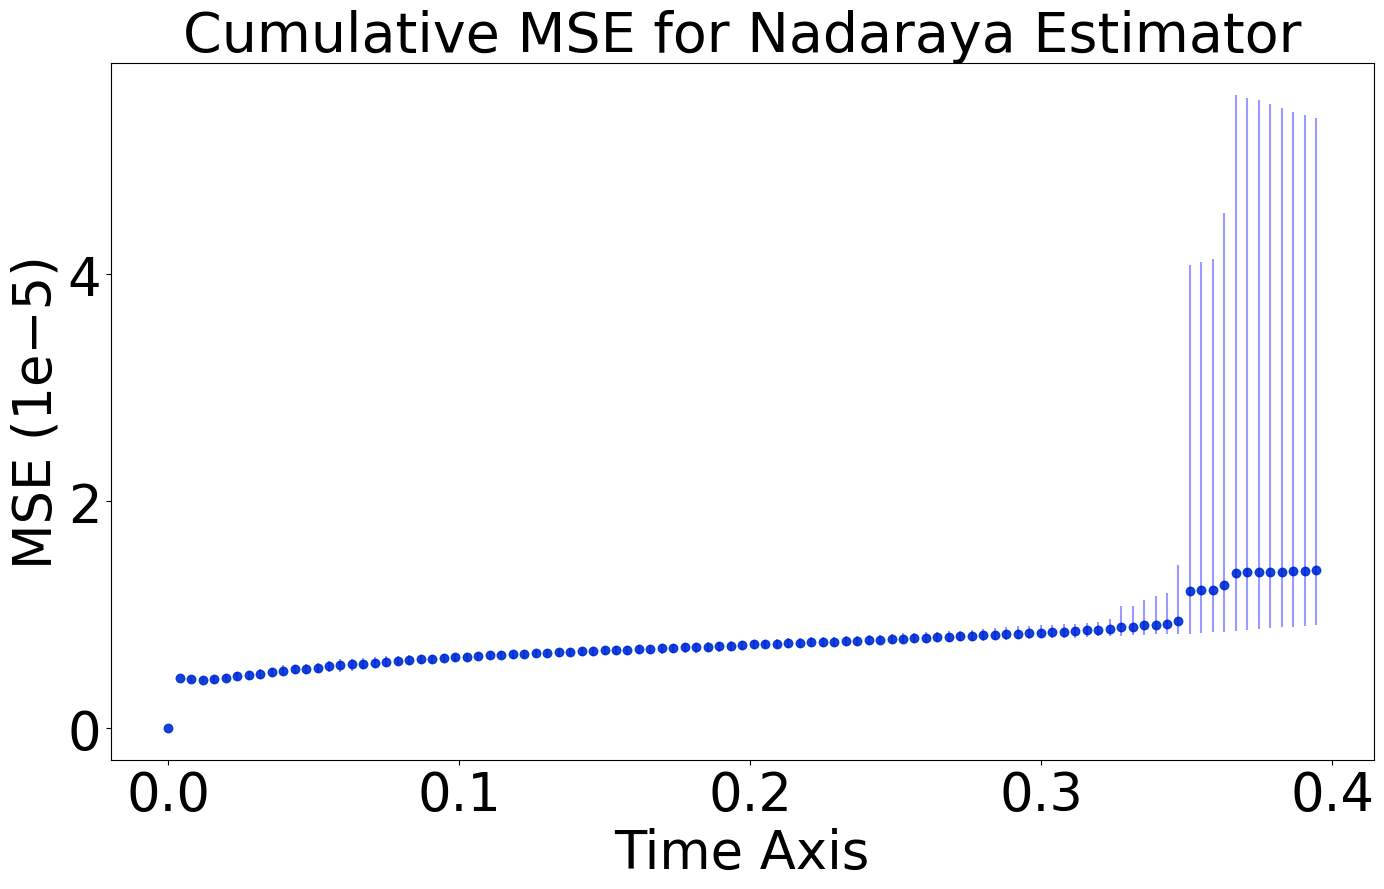

Final time cumulative MSE local-time error 1.3923035681190596e-05 with IQR ((9.038454072406115e-06, 5.371882692905712e-05))at bw 0.0021354

6.934045216795652e-06 2.1057653419944867e-06 1.3923035681190596e-05 24


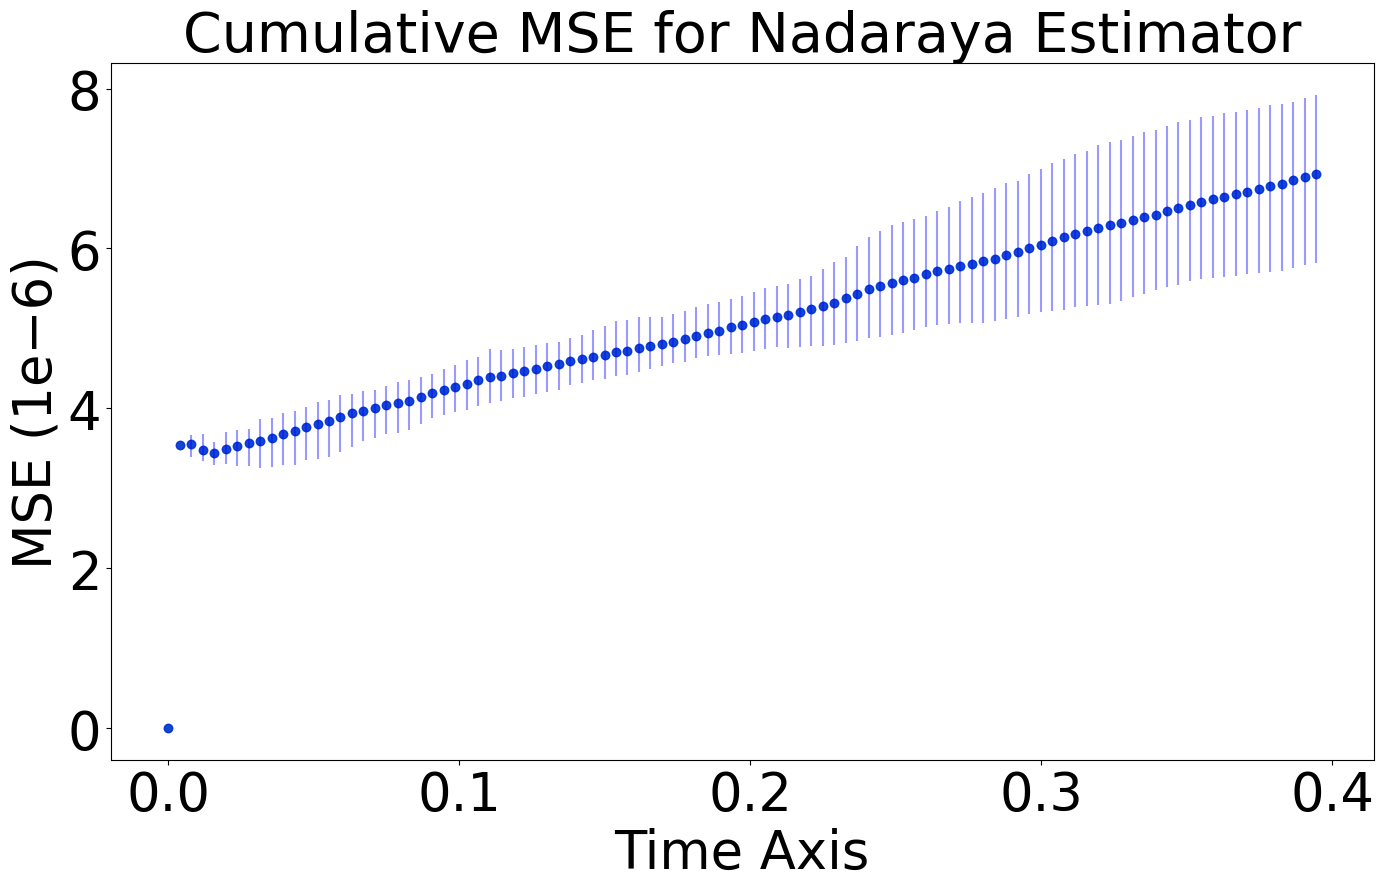

Final time cumulative MSE local-time error 6.934045216795652e-06 with IQR ((5.817798810828127e-06, 7.923564152822614e-06))at bw 0.0026963

5.7417313348278205e-06 4.850334145667967e-06 6.934045216795652e-06 25


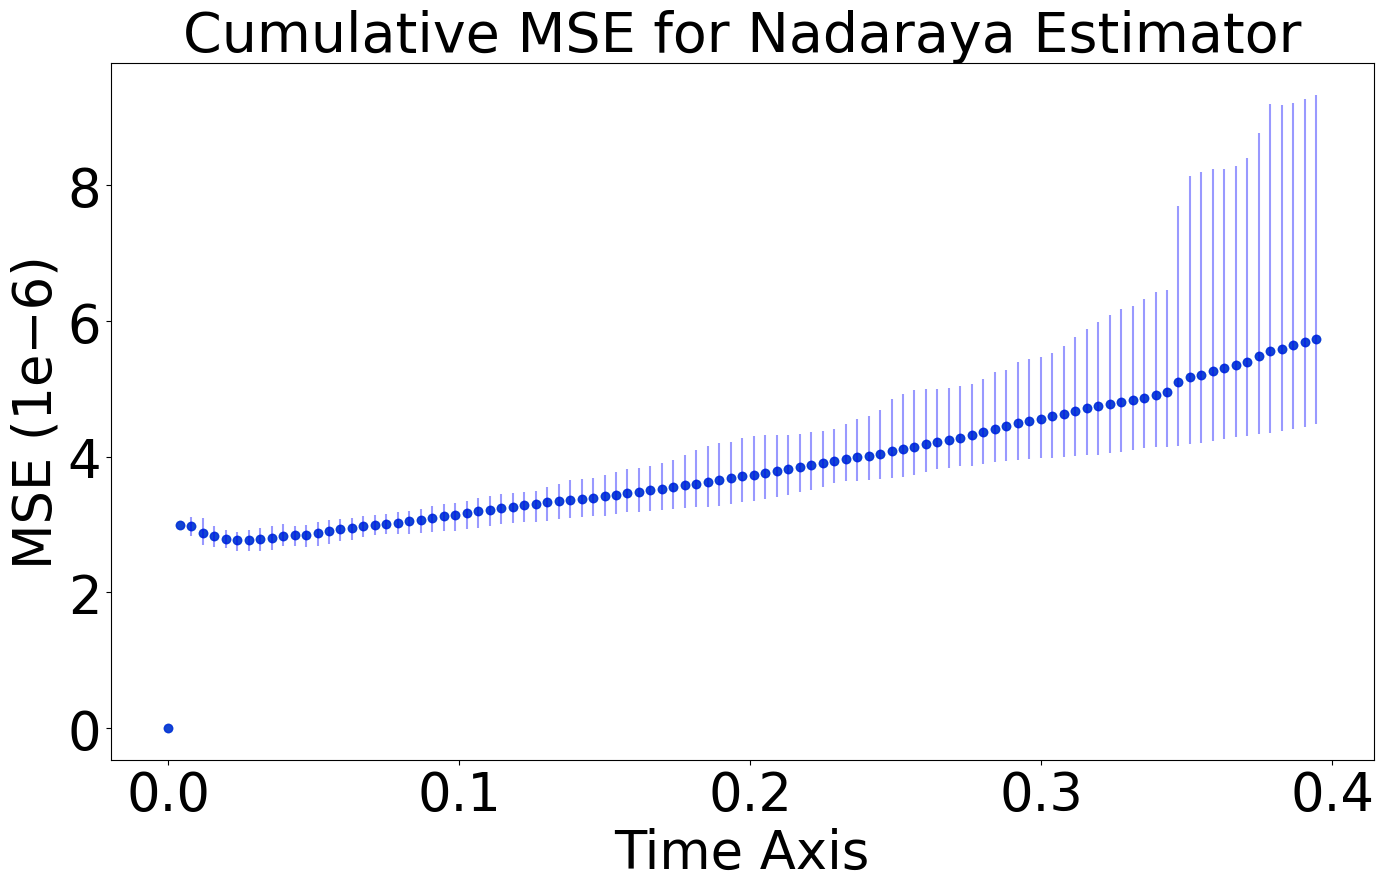

Final time cumulative MSE local-time error 5.7417313348278205e-06 with IQR ((4.48607642425364e-06, 9.336410569921607e-06))at bw 0.0034045

3.8372319171910465e-06 1.3759073680508972e-06 5.7417313348278205e-06 26


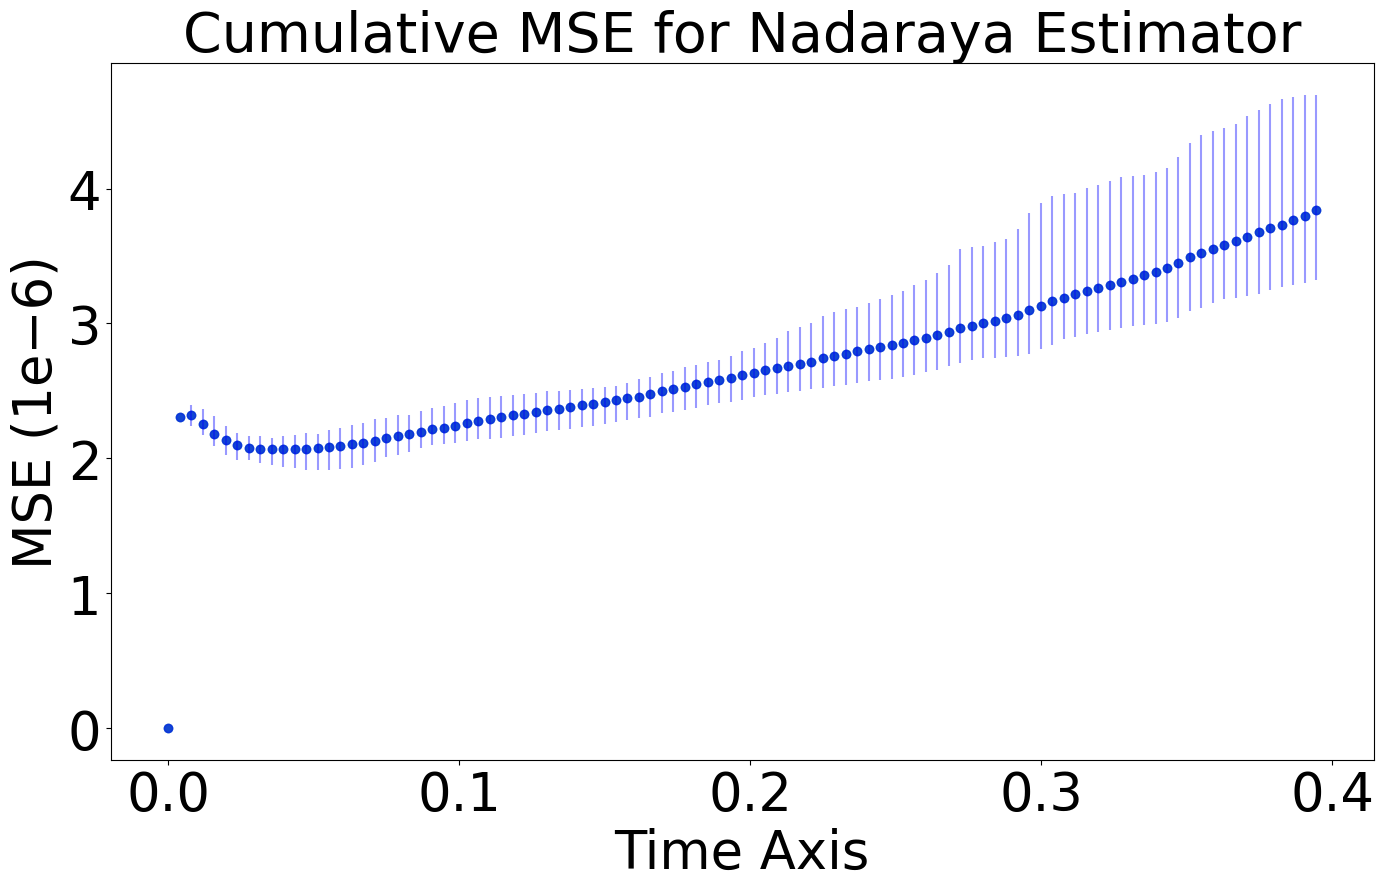

Final time cumulative MSE local-time error 3.8372319171910465e-06 with IQR ((3.31972664869036e-06, 4.695634016741257e-06))at bw 0.0042987

2.9871707561791222e-06 2.590544693613812e-06 3.8372319171910465e-06 27


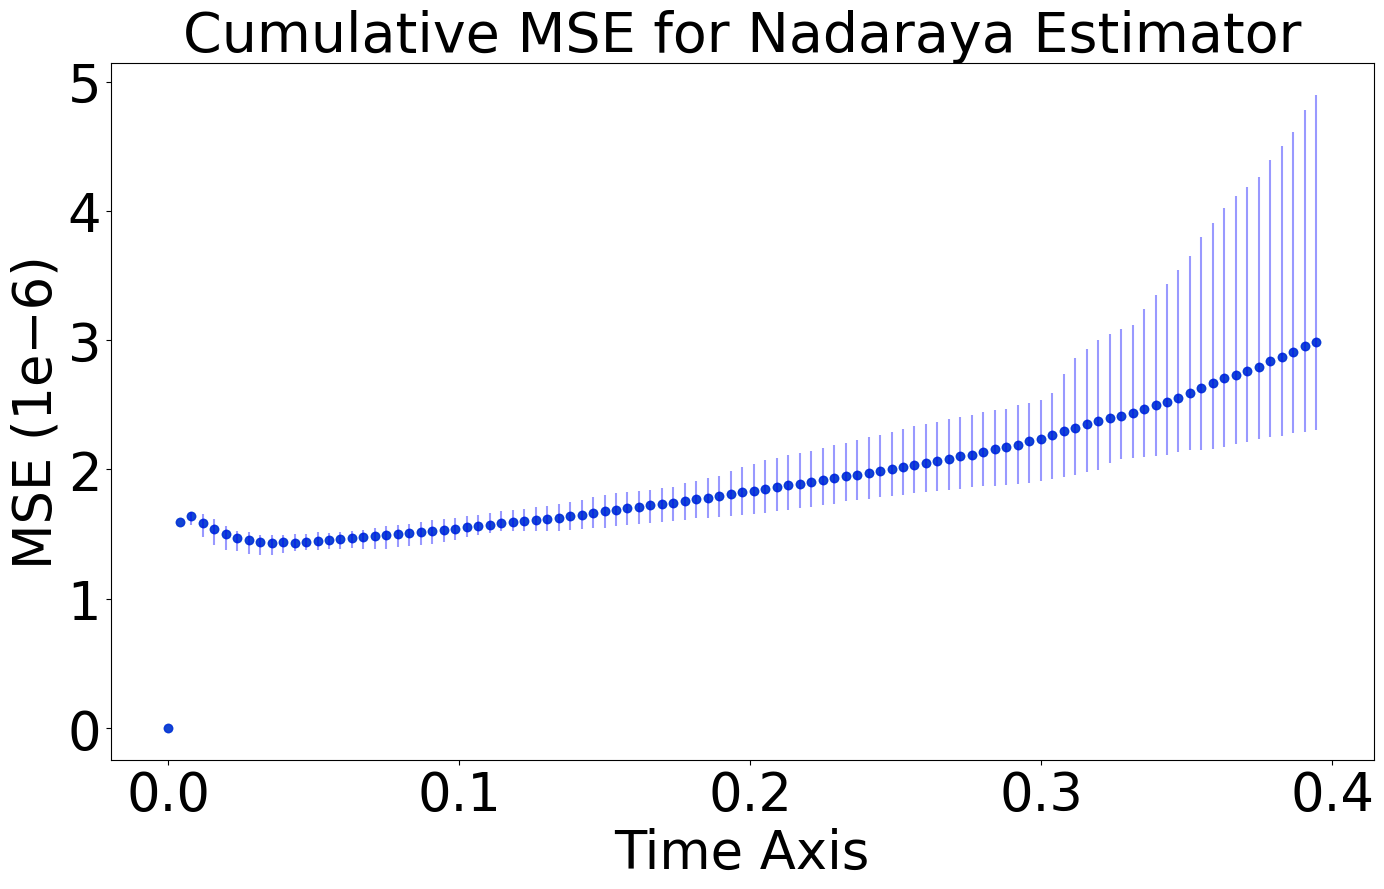

Final time cumulative MSE local-time error 2.9871707561791222e-06 with IQR ((2.3080249002579587e-06, 4.898569593871771e-06))at bw 0.0054277

2.369452902905361e-06 2.910131439181187e-06 2.9871707561791222e-06 28


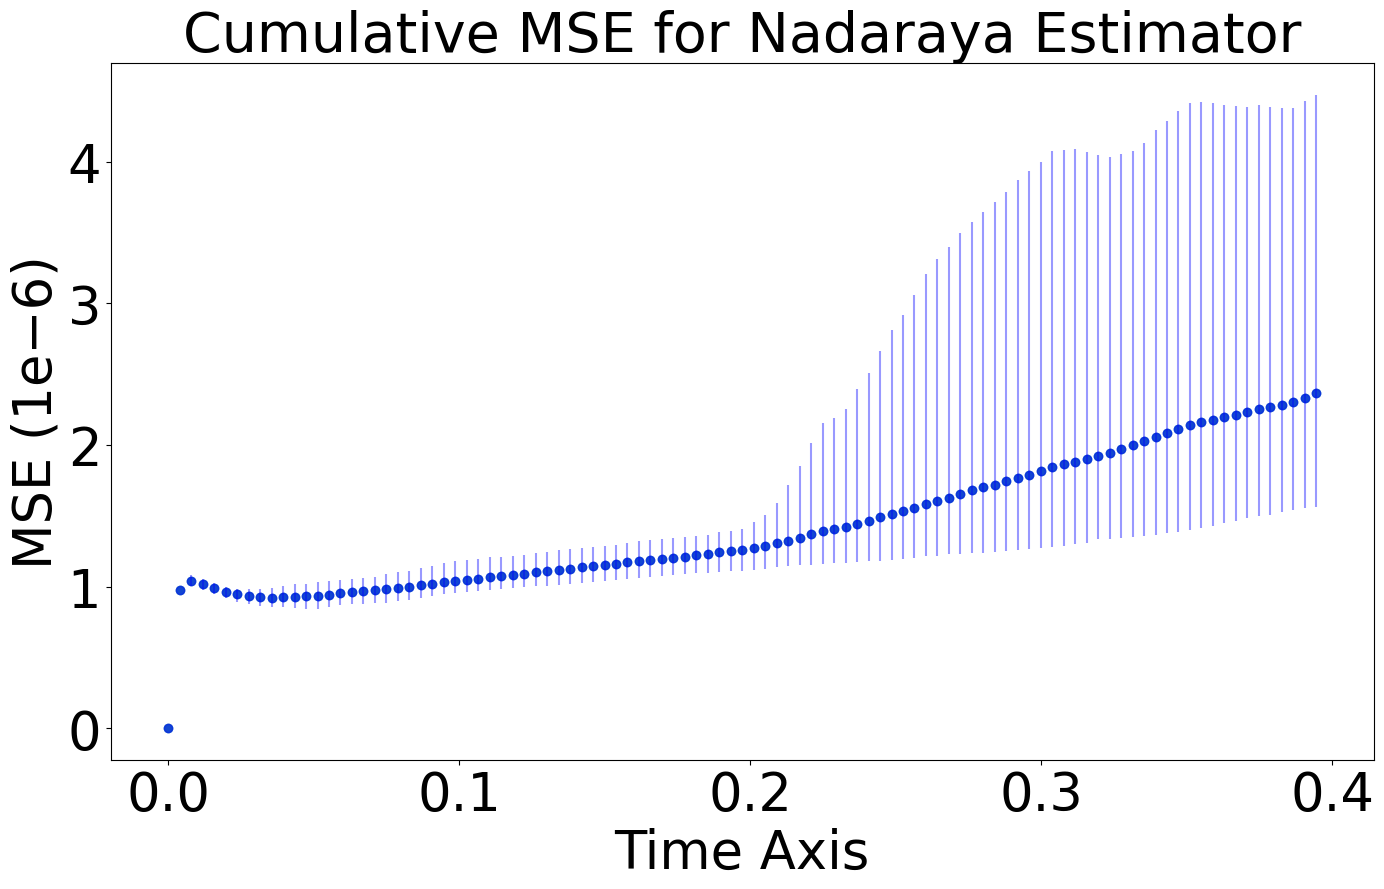

Final time cumulative MSE local-time error 2.369452902905361e-06 with IQR ((1.5646267779245257e-06, 4.4747582171057125e-06))at bw 0.0068533

2.0008901316825667e-06 3.9939182169384735e-06 2.369452902905361e-06 29


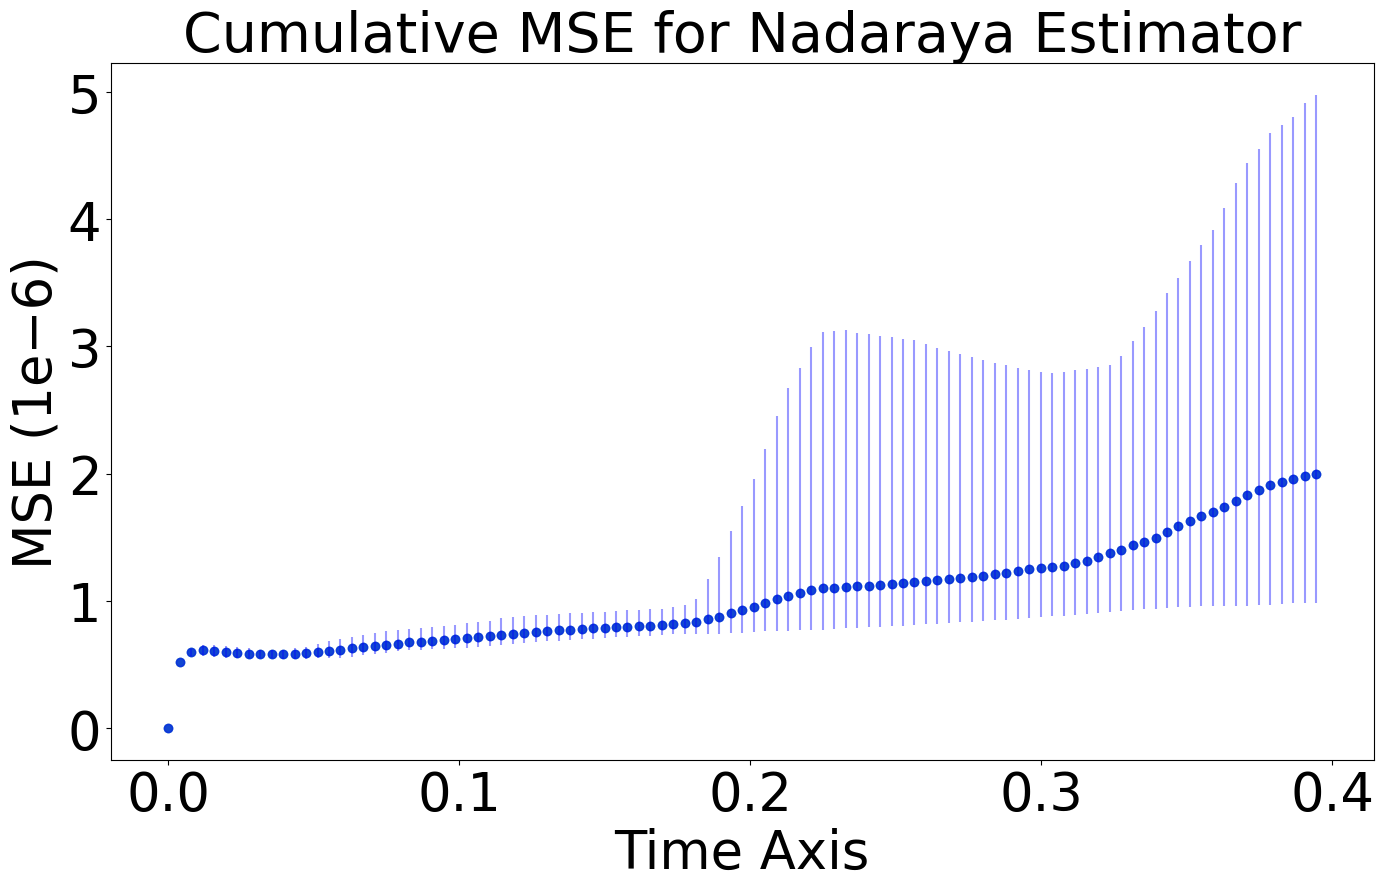

Final time cumulative MSE local-time error 2.0008901316825667e-06 with IQR ((9.86033209176428e-07, 4.979951426114901e-06))at bw 0.0086533

3.0615404505618037e-06 8.053941549049877e-06 2.0008901316825667e-06 30
5.4475450806209946e-06 1.1045572794545366e-05 2.0008901316825667e-06 31
1.3774560161552955e-05 2.010548498890889e-05 2.0008901316825667e-06 32
2.4573672116183184e-05 3.144920700403897e-05 2.0008901316825667e-06 33
4.781695493532319e-05 6.287394434558664e-05 2.0008901316825667e-06 34
8.304287739553156e-05 5.7366723074449646e-05 2.0008901316825667e-06 35
0.00015075082869644044 0.00011648213537633109 2.0008901316825667e-06 36
0.00022180206645705143 0.000235217009357628 2.0008901316825667e-06 37
0.00027509791129796024 0.00023503509474794354 2.0008901316825667e-06 38
0.0003455358448672765 0.0004191920526011683 2.0008901316825667e-06 39


In [10]:
curr_mse = np.inf
toSave = True
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])/np.sqrt(config.deltaT)
    all_local_states = np.load(file[1])/np.sqrt(config.deltaT)
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean((all_local_errors), axis=0)
        total_local_errors_minq = np.quantile((all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile((all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_mse, i)
        i += 1
        if i == 1: continue
        if total_local_errors[-1]  < curr_mse:
            miny = total_local_errors-total_local_errors_minq
            miny[miny < 0.] = 0.
            maxy = total_local_errors_maxq-total_local_errors
            maxy[maxy < 0.] = 0.
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_mse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0]), total_local_errors)
            plt.errorbar(time_steps,total_local_errors,yerr=[miny, maxy],xerr=None, fmt='o', color="blue", alpha=0.4)
            ax.set_title(f"Cumulative MSE for Nadaraya Estimator",fontsize=40)

            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)

            fig.canvas.draw()
            # Get the offset text (e.g., '1e-5')
            offset_text = ax.yaxis.get_offset_text().get_text()

            # Remove the offset text from the axis
            ax.yaxis.get_offset_text().set_visible(False)

            # Inject the scale into the y-axis label
            if offset_text:
                ax.set_ylabel(f'MSE ({offset_text})', fontsize=38)
            else:
                ax.set_ylabel('MSE', fontsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/IIDNadaraya_{ts_type}_DriftTrack_{round(bw, 6)}bw_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw}\n")